In [2]:
from plugins.calibration.sn_calibration_baseline.camera import Camera, pan_tilt_roll_to_orientation, rotation_matrix_to_pan_tilt_roll
from scipy.signal import savgol_filter
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
import numpy as np
from scipy.signal import medfilt

# plt.rcParams['figure.figsize'] = [10, 10]

# Preprocessing - Refine camera parameters

## Initial camera parameters filtering

In [2]:
# # Ground truth camera parameters
# camParamsPath = "Labels-GameState360.json"
# with open(camParamsPath, "r") as f:
# 	camParams = json.load(f)["annotations"]
# camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
# len(camParams)

In [3]:
camParamsPath = "cam_params.json"
with open(camParamsPath, "r") as f:
    camParams = json.load(f)
len(camParams)

750

In [4]:
cam = Camera()

### Interpolation of neighboring complete parameters to replace non complete parameters with an aproximation

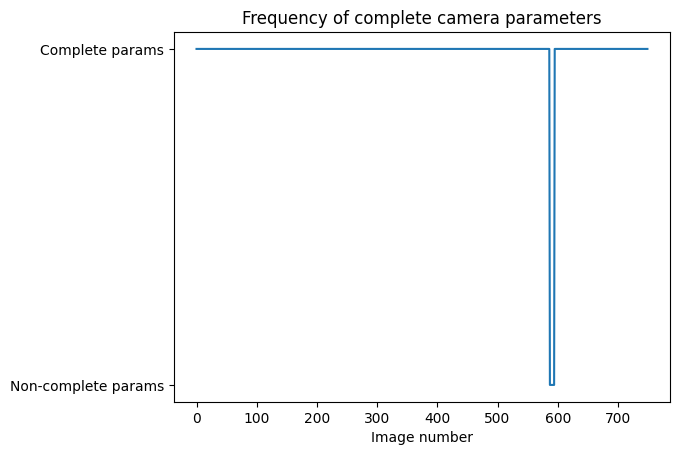

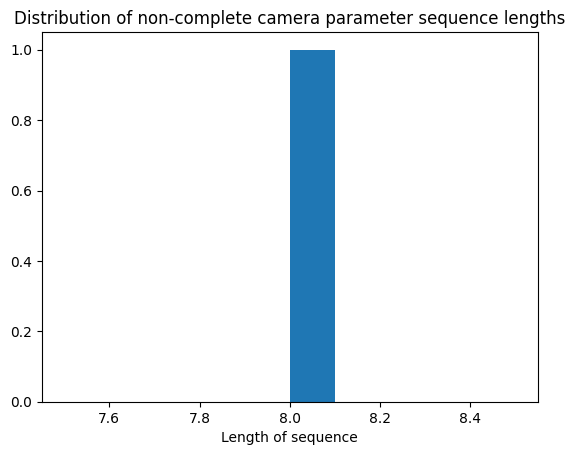

In [5]:
completeParams = np.zeros(len(camParams), dtype=np.bool_)
distOfNonCompleteParams = []
currDist = 0
for i, params in enumerate(camParams):
    if type(params) is dict:
        completeParams[i] = True
        if currDist > 0:
            distOfNonCompleteParams.append(currDist)
            currDist = 0
    else:
        completeParams[i] = False
        currDist += 1

plt.plot(completeParams)
plt.title("Frequency of complete camera parameters")
# Change y axis to show "complete params" and "non-complete params" instead of 0 and 1
plt.yticks([0, 1], ["Non-complete params", "Complete params"])
plt.xlabel("Image number")
plt.show()
plt.hist(distOfNonCompleteParams)
plt.title("Distribution of non-complete camera parameter sequence lengths")
plt.xlabel("Length of sequence")
plt.show()

In [6]:
# Replace non-complete camera parameters with a temporary and random complete camera parameter. This way, linear interpolation will be able to modify 'pan_degrees', 'tilt_degrees', 'roll_degrees', 'position_meters', ...
for param in camParams:
    if type(param) == dict:
        tmpCompleteParam = param
        break
isErroneousParams = np.array([type(x) != dict for x in camParams])
ErroneousParamsPos = np.where(isErroneousParams)[0]
for pos in ErroneousParamsPos:
    camParams[pos] = tmpCompleteParam

<!-- Apply the basic solution to replace non complete camera parameters with a complete parameter. For example the non complete parameter can be the homography matrix, which do not contain all the camera parameters. In that case the missing parameters can be aproximated by using the previous camera parameters. -->

In [7]:
indCamParams = {
    "pan_degrees": [x["pan_degrees"] for x in camParams],
    "tilt_degrees": [x["tilt_degrees"] for x in camParams],
    "roll_degrees": [x["roll_degrees"] for x in camParams],
    "position_meters": [x["position_meters"] for x in camParams],
    "x_focal_length": [x["x_focal_length"] for x in camParams],
    "y_focal_length": [x["y_focal_length"] for x in camParams],
    "principal_point": [x["principal_point"] for x in camParams],
    "radial_distortion": [x["radial_distortion"] for x in camParams],
    "tangential_distortion": [x["tangential_distortion"] for x in camParams],
    "thin_prism_distortion": [x["thin_prism_distortion"] for x in camParams]
}
# # Ground truth do not have "rep_err" field
# if "rep_err" in camParams[0]:
# 	indCamParams["rep_err"] = [x["rep_err"] for x in camParams]

for key in indCamParams:
    indCamParams[key] = np.array(indCamParams[key])   # type: ignore

Linear interpolation of non complete camera parameters.

In [8]:
xp = []  # positions of complete camera parameters next to non-complete camera parameters
if not isErroneousParams[0] and isErroneousParams[1]:
    xp.append(0)
if not isErroneousParams[-1] and isErroneousParams[-2]:
    xp.append(len(camParams) - 1)
for i in range(1, len(camParams) - 1):
    if not isErroneousParams[i] and (isErroneousParams[i - 1] or isErroneousParams[i + 1]):
        xp.append(i)
for key, value in indCamParams.items():
    if len(value.shape) == 1:
        indCamParams[key][ErroneousParamsPos] = np.interp(ErroneousParamsPos, xp, value[xp])
    else: # 2D array
        for i in range(value.shape[1]):
            indCamParams[key][ErroneousParamsPos, i] = np.interp(ErroneousParamsPos, xp, value[xp, i])

In [9]:

indCamParamsOrig = deepcopy(indCamParams)

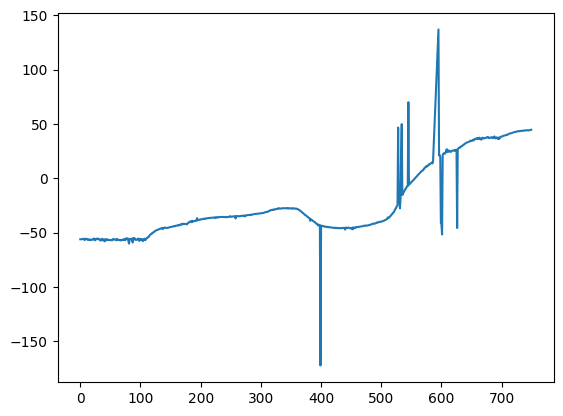

In [10]:
plt.plot(indCamParams["pan_degrees"], label="pan_degrees")

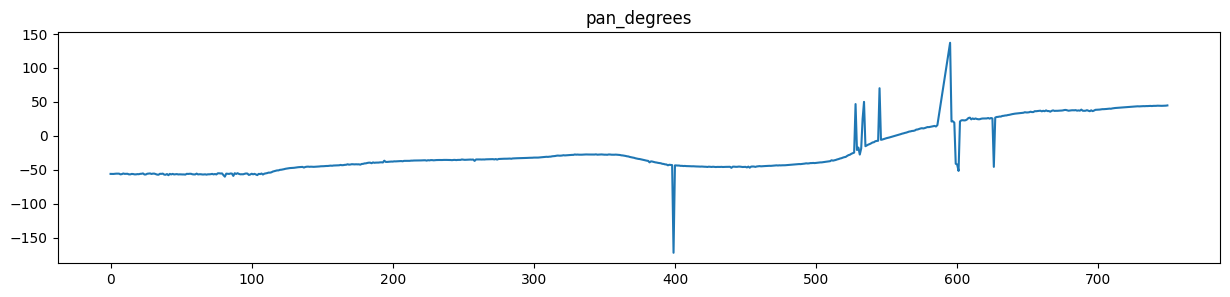

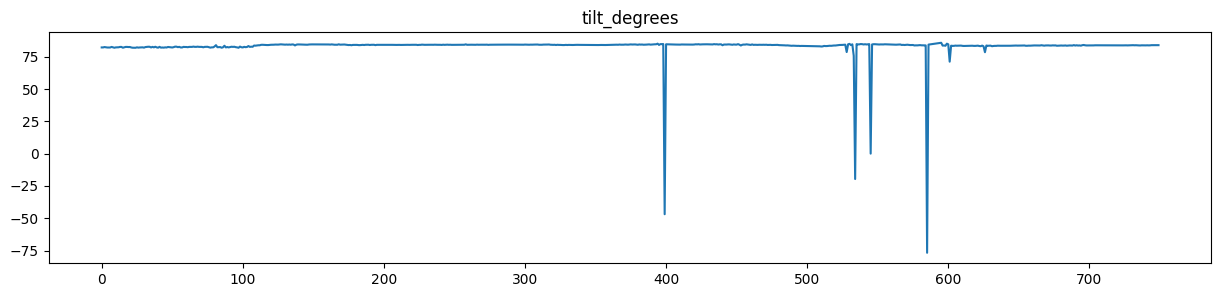

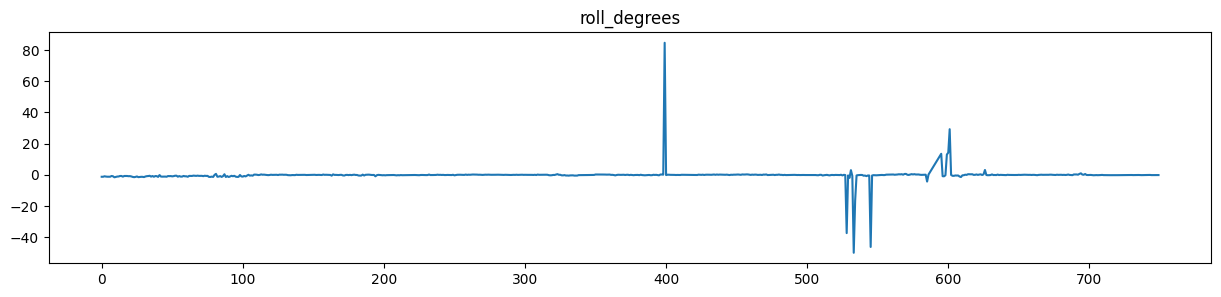

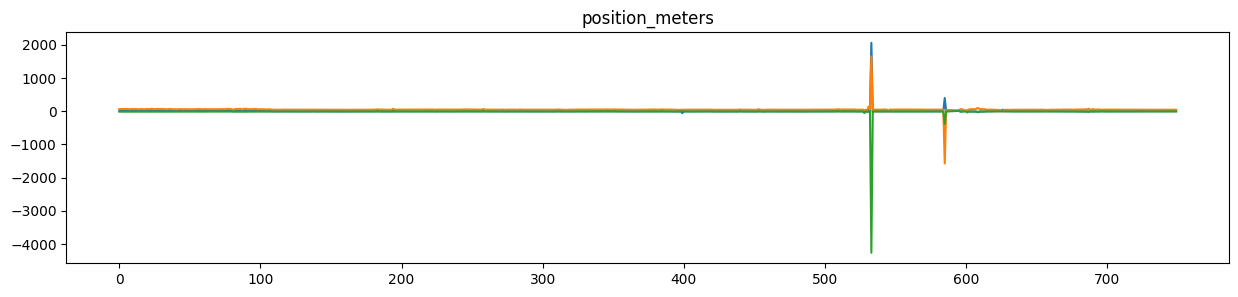

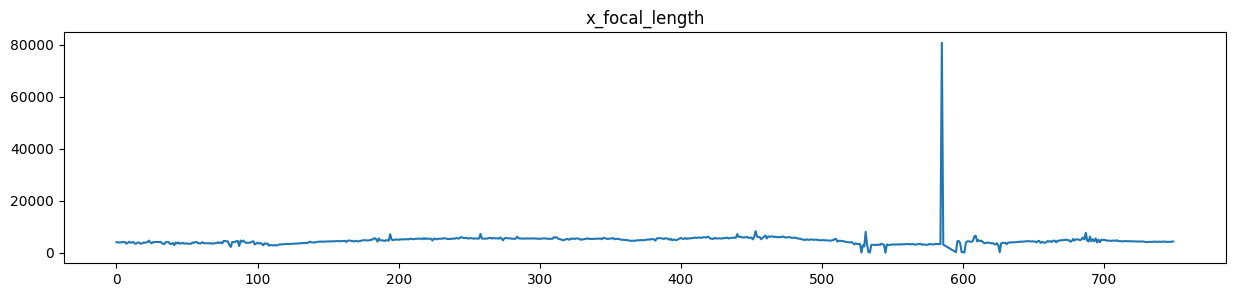

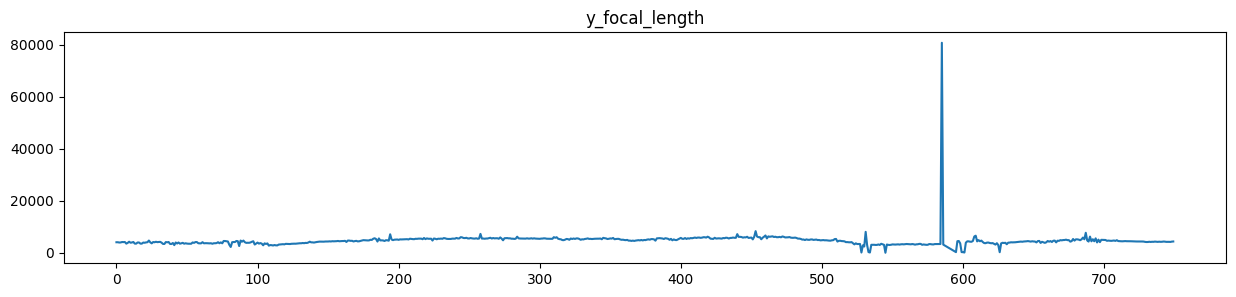

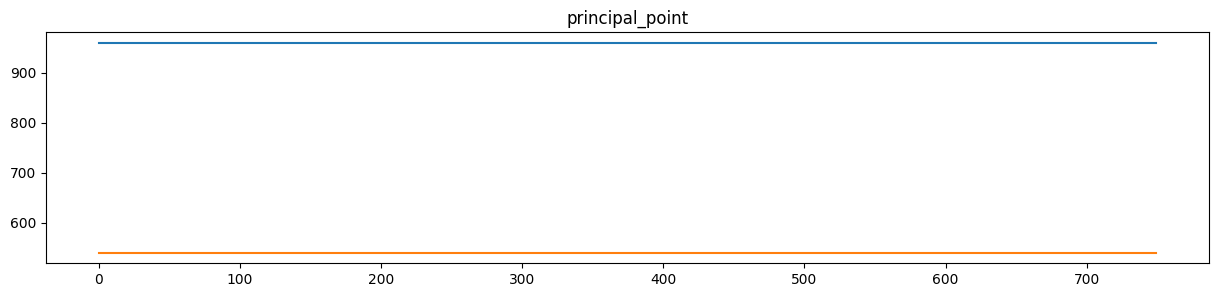

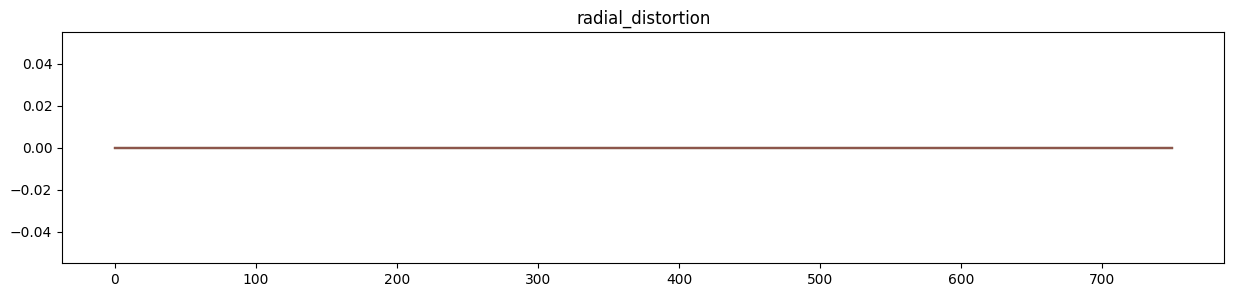

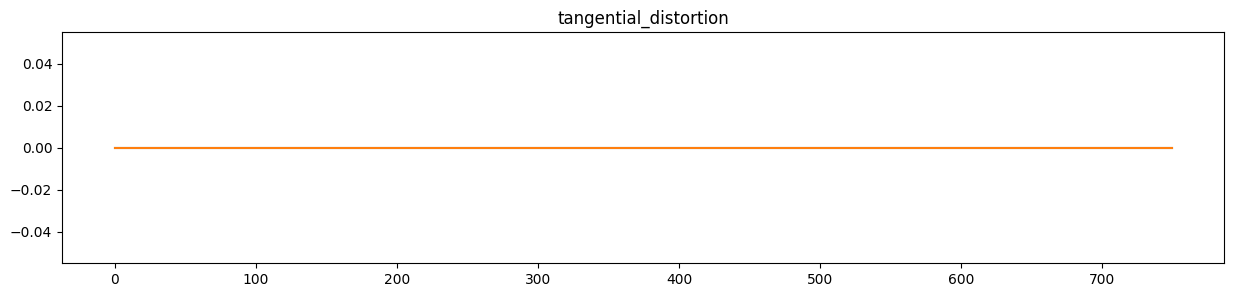

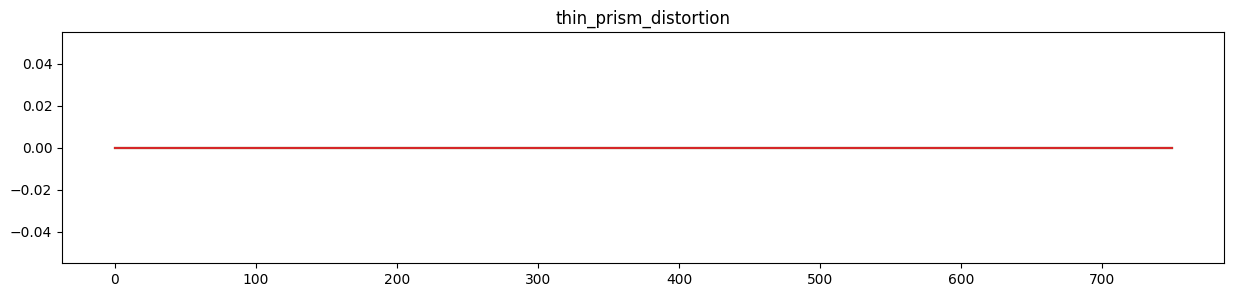

In [11]:
# plot each key in indCamParams in a subplot
for key in indCamParams.keys():
    plt.figure(figsize=(15, 3))
    plt.plot(indCamParams[key])
    plt.title(key)
    plt.show()

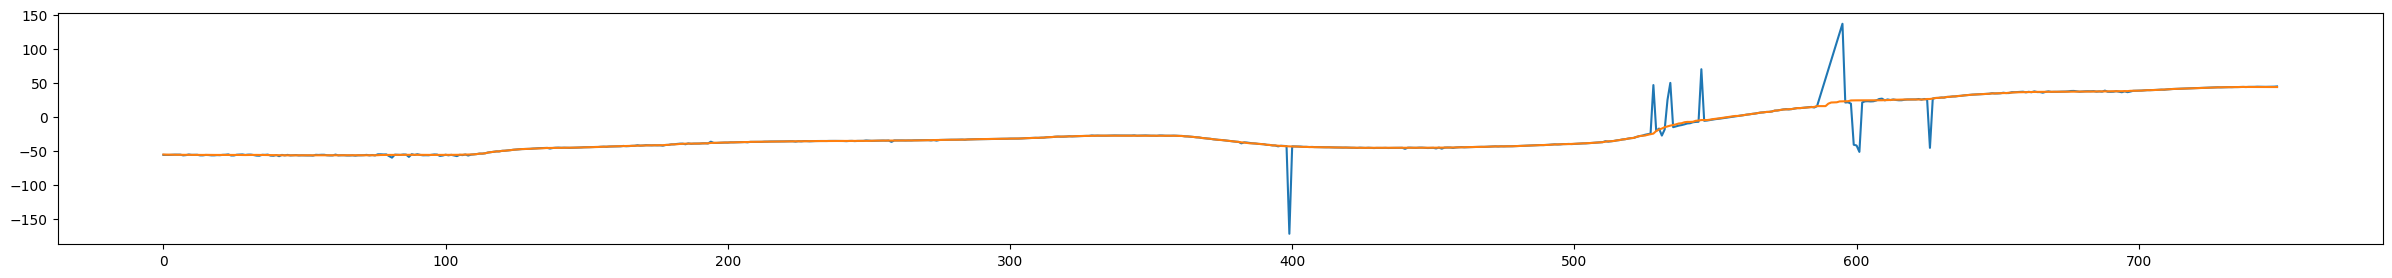

In [12]:
range_frames = np.arange(0, 750)
plt.figure(figsize=(30, 3))
plt.plot(indCamParams["pan_degrees"][range_frames], label="pan_degrees")
# plt.plot(indCamParams["rep_err"][range_frames], label="rep_err")
plt.plot(medfilt(indCamParams["pan_degrees"], 25)[range_frames], label="pan_degrees medfilt")
# limit range of y axis between -60 and 50
# plt.ylim(-60, 50)

1.9224864556627683


(0.0, 3.8449729113255366)

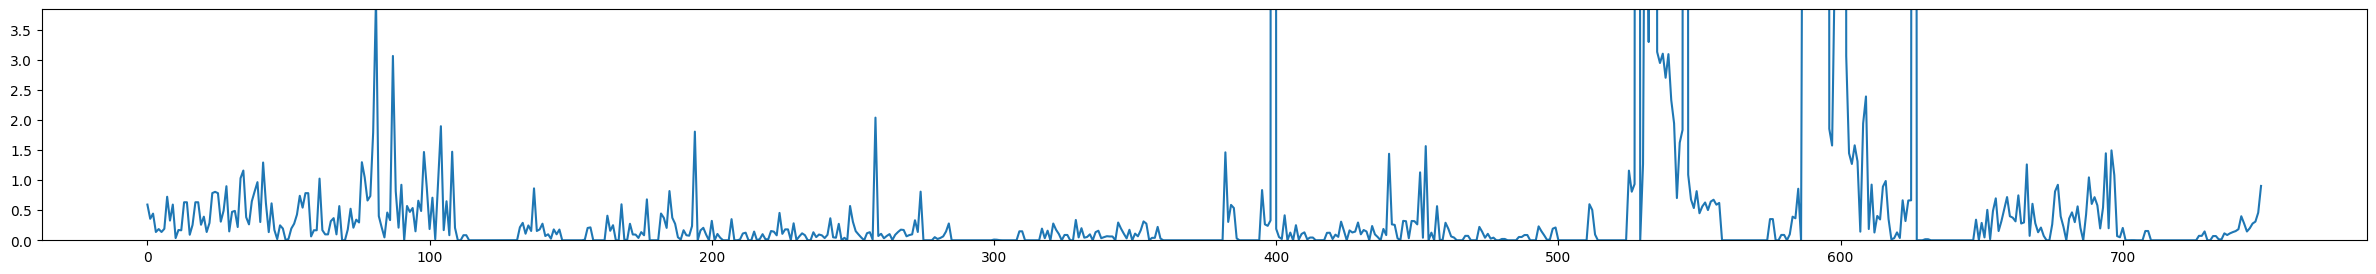

In [13]:
pan_degrees = indCamParams["pan_degrees"]
median_filtered_pan_degrees = medfilt(pan_degrees, 25)
abs_diff_pan_degrees = np.abs(pan_degrees - median_filtered_pan_degrees)
plt.figure(figsize=(30, 3))
plt.plot(abs_diff_pan_degrees[range_frames], label="abs_diff_pan_degrees")
mean_abs_diff_pan_degrees = np.mean(abs_diff_pan_degrees)
print(mean_abs_diff_pan_degrees)
plt.ylim(0, mean_abs_diff_pan_degrees * 2)

In [14]:
np.sum(abs_diff_pan_degrees > mean_abs_diff_pan_degrees * 2)

21

initial len(ErroneousParamsPos): 8


(-60.0, 50.0)

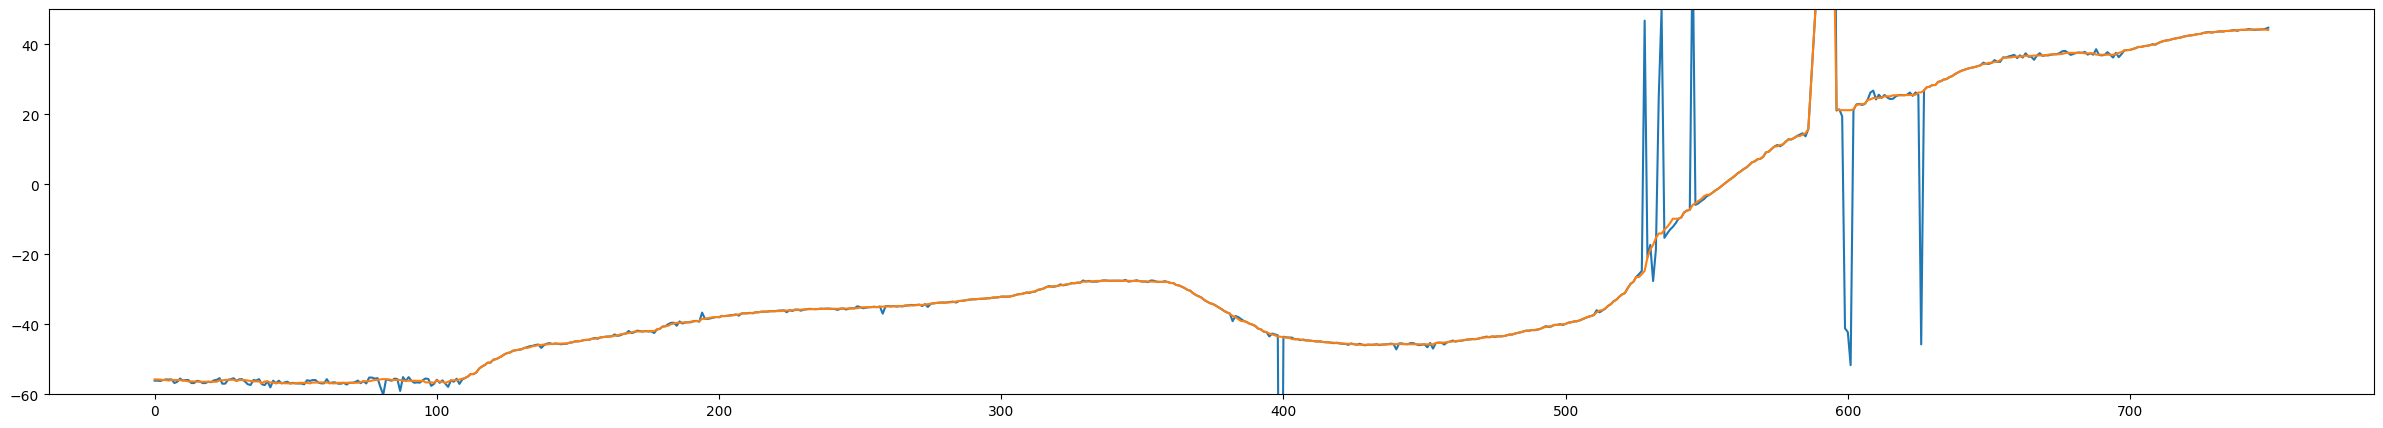

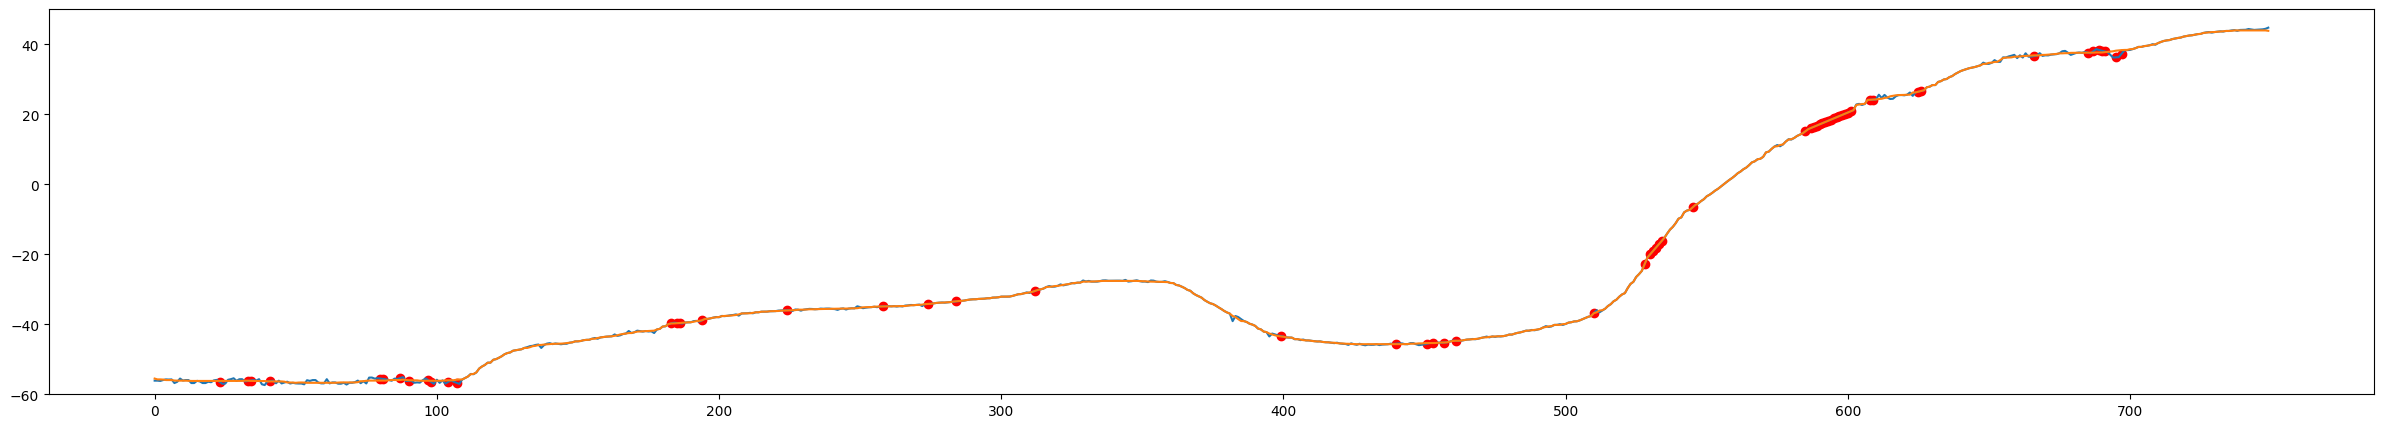

In [15]:
correctedIndCamParams = deepcopy(indCamParams)

plt.figure(figsize=(30, 5))
plt.plot(correctedIndCamParams["pan_degrees"], label="pan_degrees")
plt.plot(medfilt(correctedIndCamParams["pan_degrees"], 11), label="pan_degrees medfilt")
plt.ylim(-60, 50)
print("initial len(ErroneousParamsPos):", len(ErroneousParamsPos))

for paramName, paramValues2d in correctedIndCamParams.items():
    if len(paramValues2d.shape) == 1:
        paramValues2d = np.array([paramValues2d])
    else:
        paramValues2d = paramValues2d.T

    for paramValues1d in paramValues2d:
        # pan_degrees = correctedIndCamParams["pan_degrees"]
        median_filtered_param_values = medfilt(paramValues1d, 11)
        abs_diff_param_values = np.abs(paramValues1d - median_filtered_param_values)
        mean_abs_diff_param_values = np.mean(abs_diff_param_values)
        newErroneousParamsPos = np.where(abs_diff_param_values > mean_abs_diff_param_values * 2)[0]
        ErroneousParamsPos = np.union1d(ErroneousParamsPos, newErroneousParamsPos)
        isErroneousParams = np.zeros(len(camParams), dtype=np.bool_)
        isErroneousParams[ErroneousParamsPos] = True

# linear interpolation of erroneous camera parameters
xp = []  # positions of complete camera parameters next to non-complete camera parameters
if not isErroneousParams[0] and isErroneousParams[1]:
    xp.append(0)
if not isErroneousParams[-1] and isErroneousParams[-2]:
    xp.append(len(camParams) - 1)
for i in range(1, len(camParams) - 1):
    if not isErroneousParams[i] and (isErroneousParams[i - 1] or isErroneousParams[i + 1]):
        xp.append(i)

for key, value in correctedIndCamParams.items():
    if len(value.shape) == 1:
        correctedIndCamParams[key][ErroneousParamsPos] = np.interp(ErroneousParamsPos, xp, value[xp])
    else: # 2D array
        for i in range(value.shape[1]):
            correctedIndCamParams[key][ErroneousParamsPos, i] = np.interp(ErroneousParamsPos, xp, value[xp, i])

plt.figure(figsize=(30, 5))
plt.plot(correctedIndCamParams["pan_degrees"], label="pan_degrees")
plt.plot(medfilt(correctedIndCamParams["pan_degrees"], 25), label="pan_degrees medfilt")
plt.scatter(ErroneousParamsPos, correctedIndCamParams["pan_degrees"][ErroneousParamsPos], color="red")
plt.ylim(-60, 50)

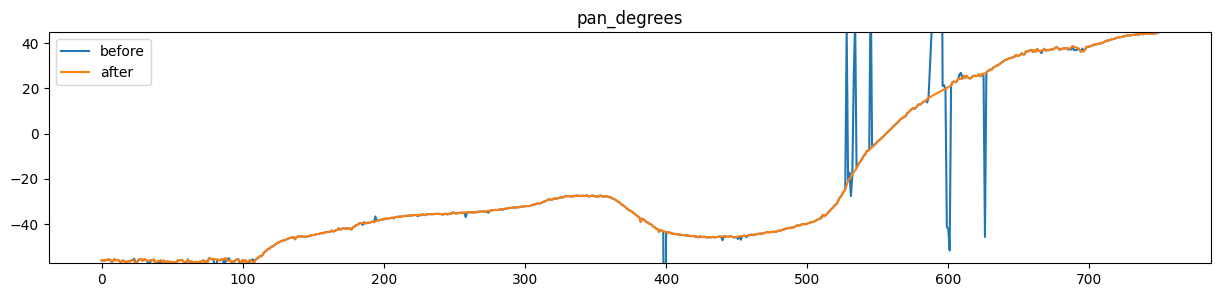

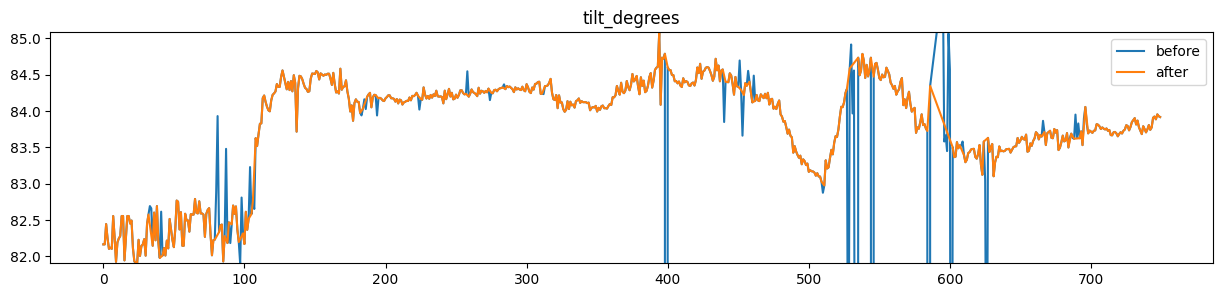

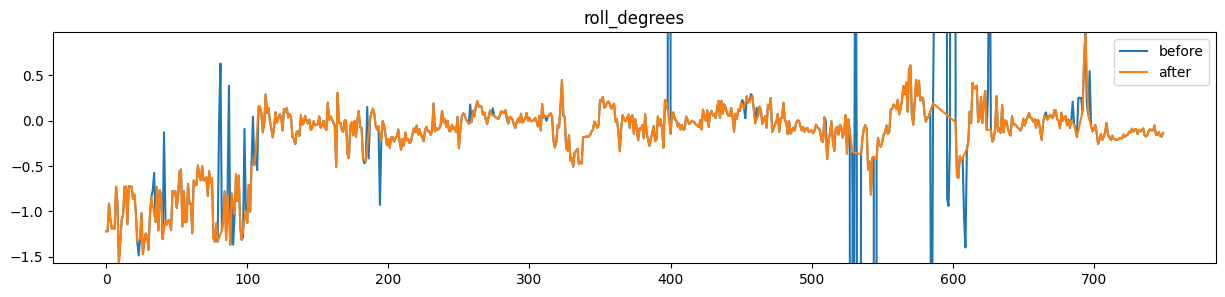

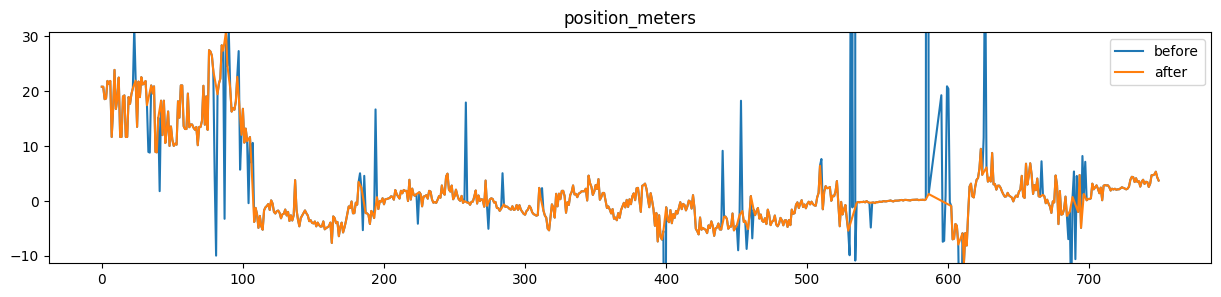

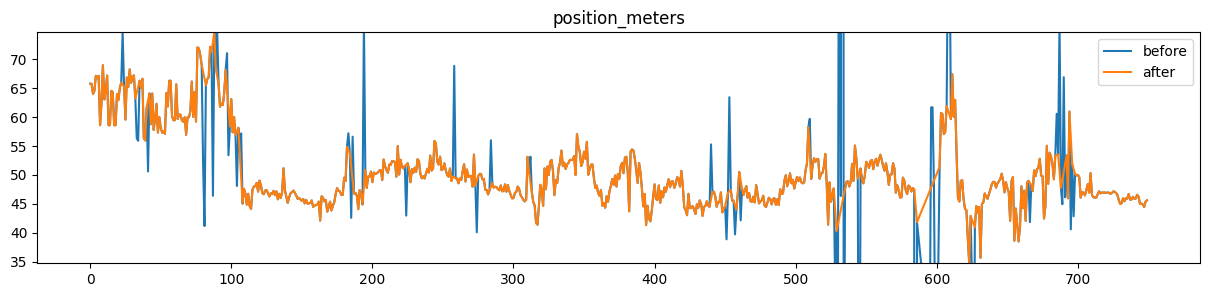

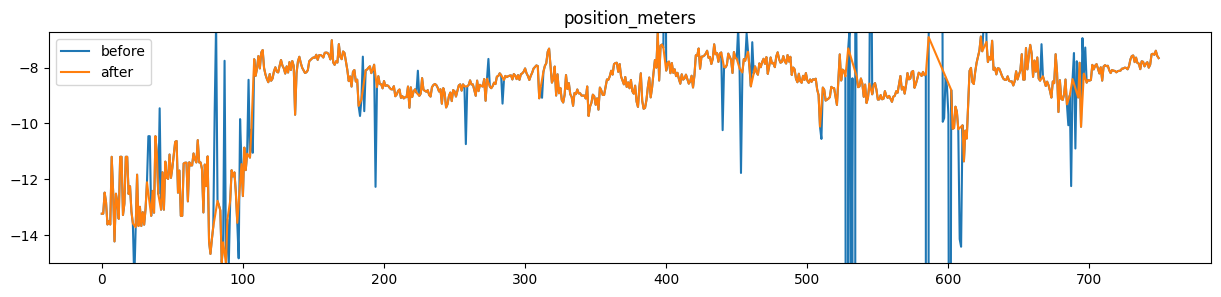

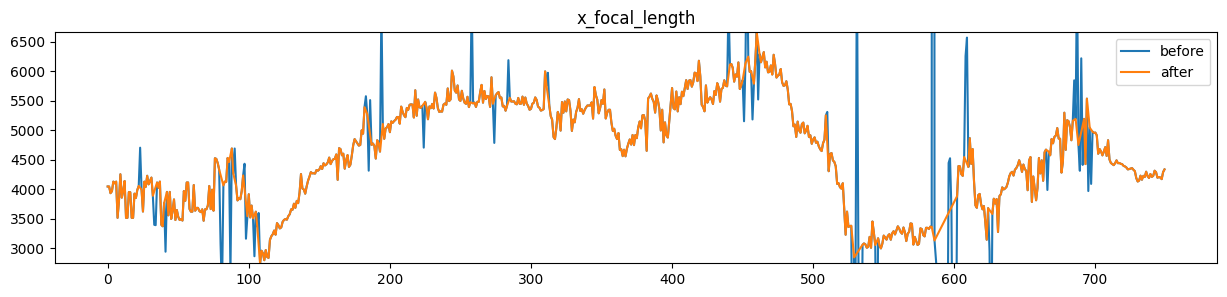

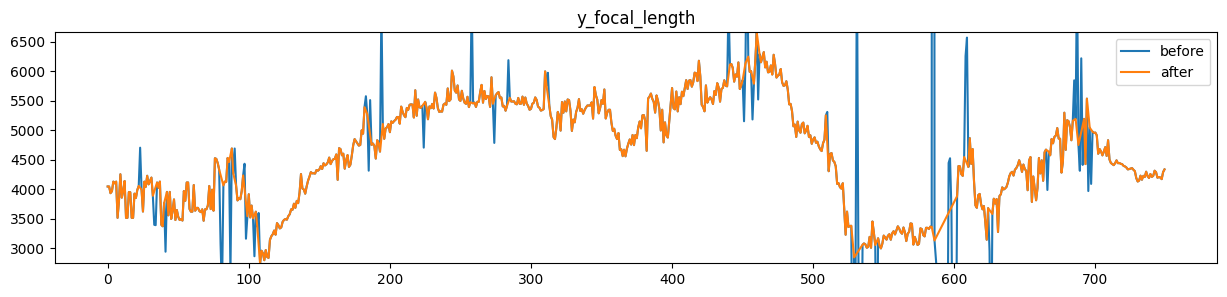

/tmp/ipykernel_2858/2648122982.py:19: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.min(correctedValues1d), np.max(correctedValues1d))


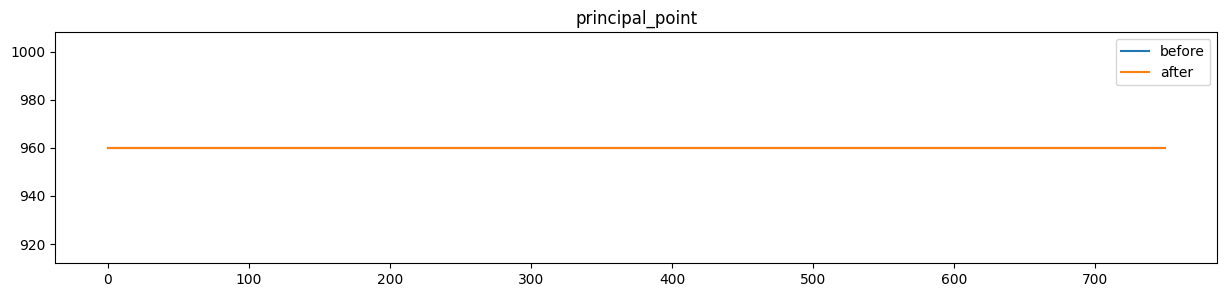

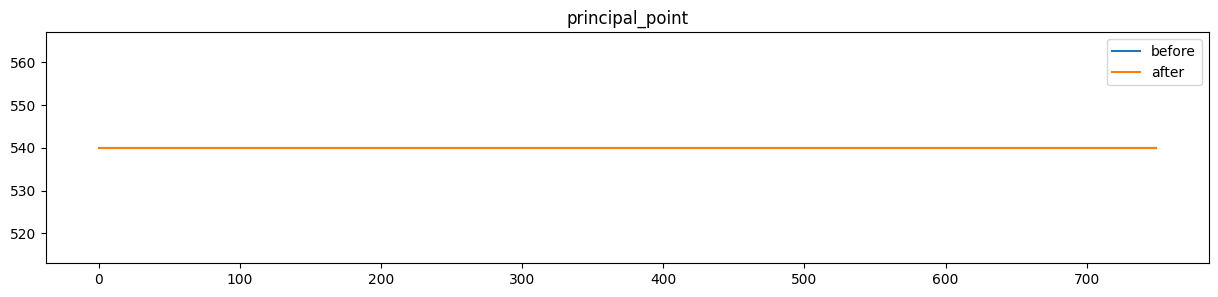

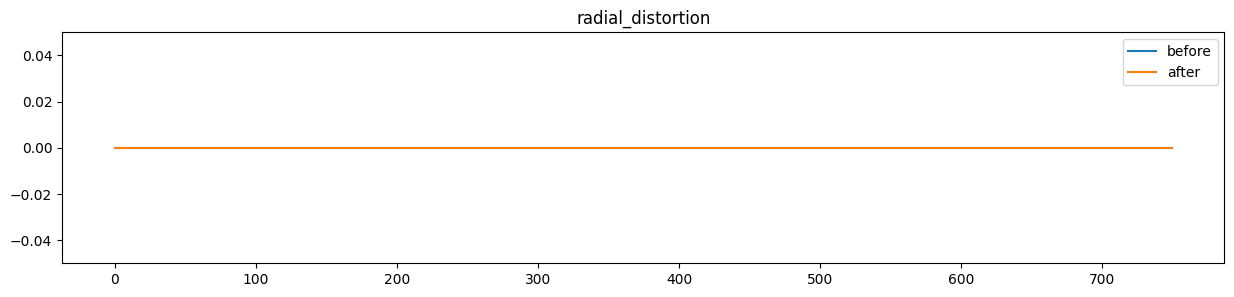

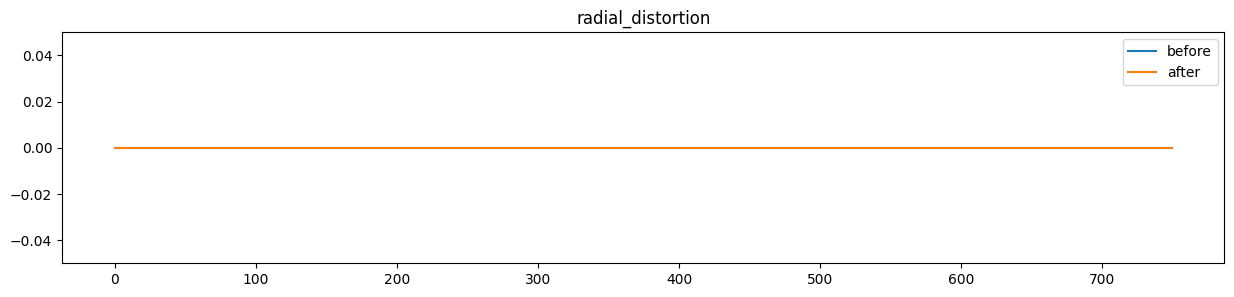

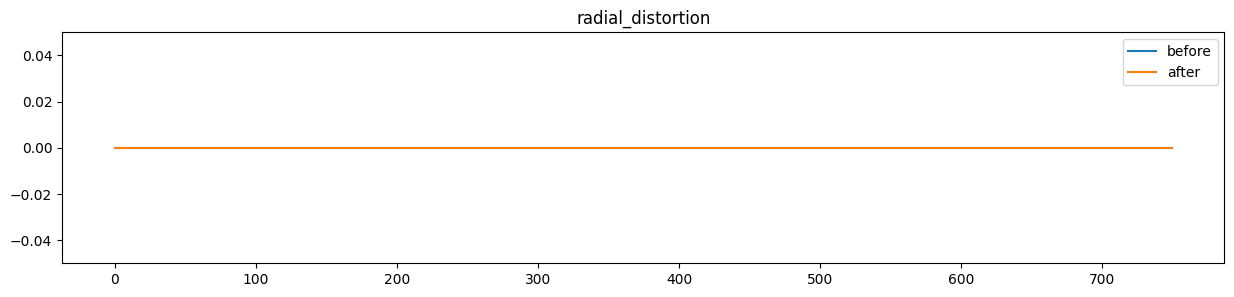

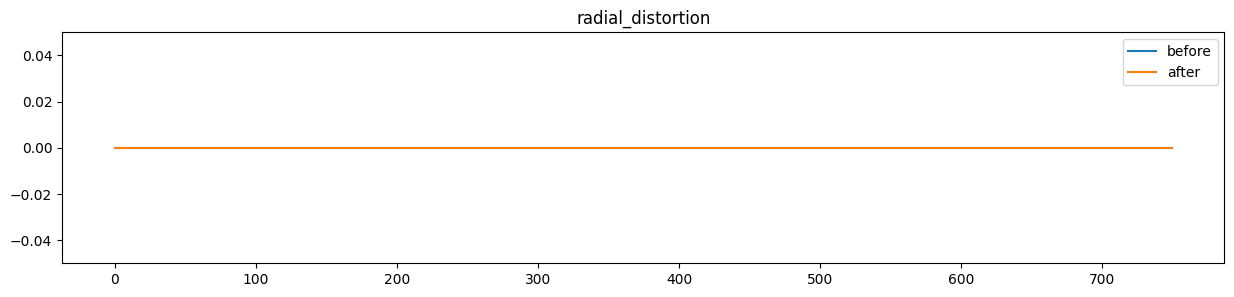

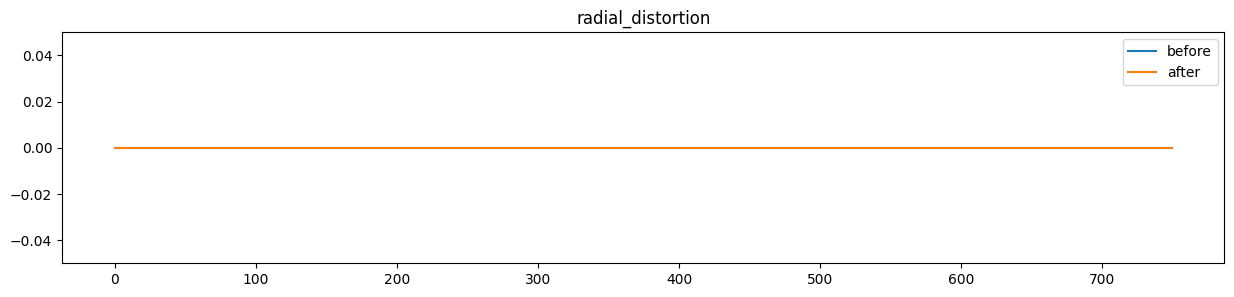

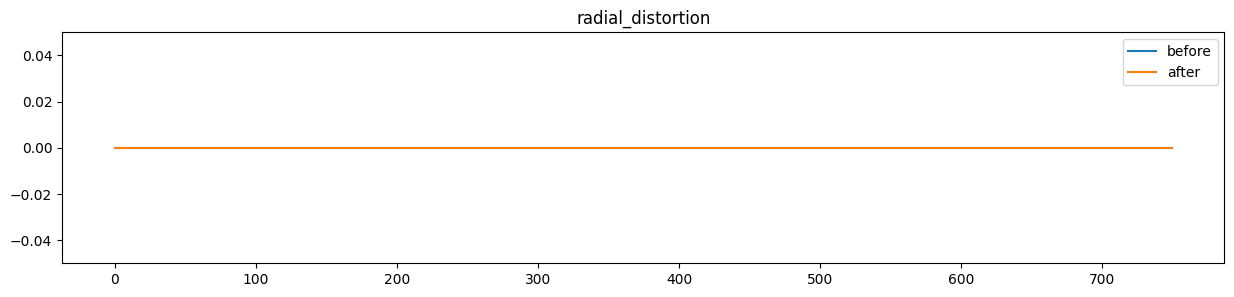

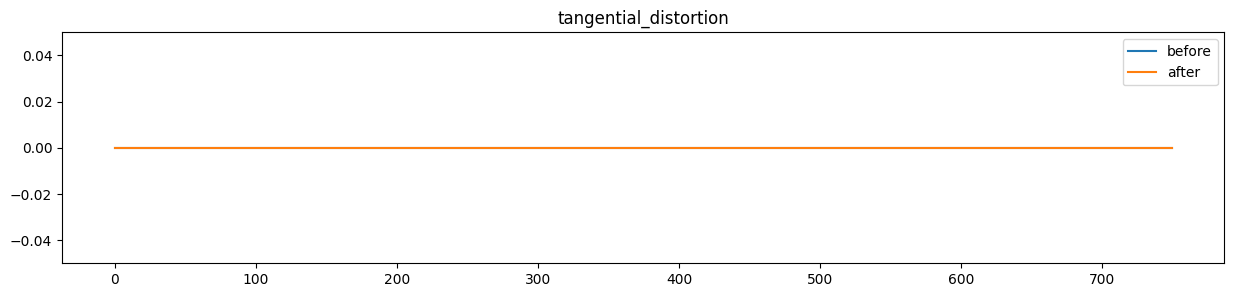

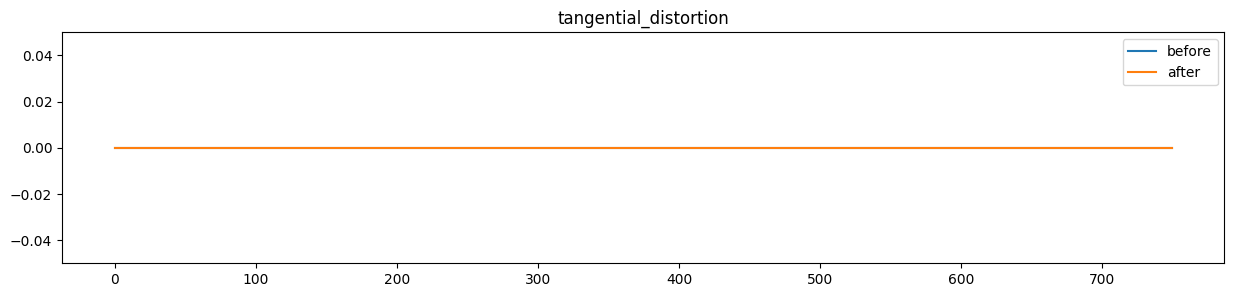

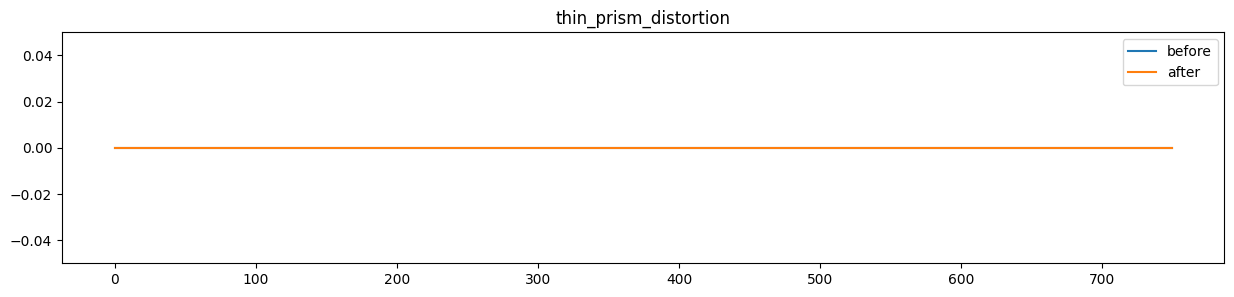

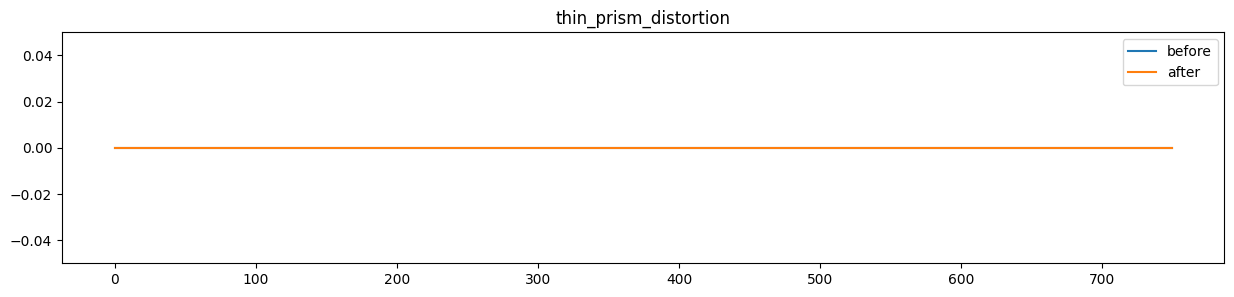

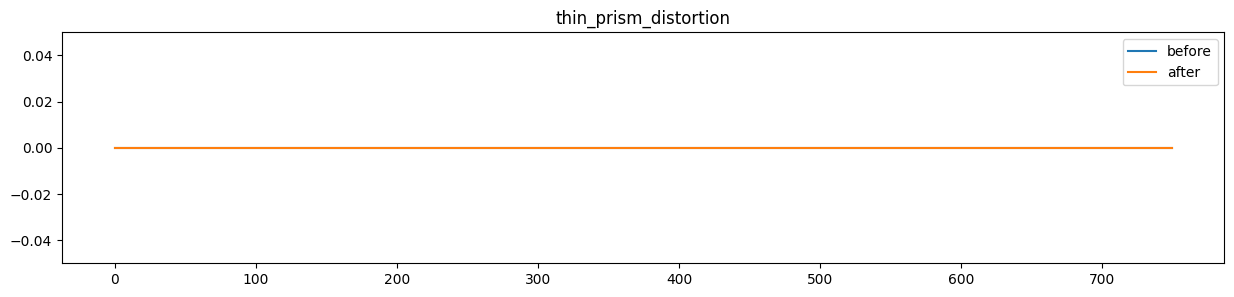

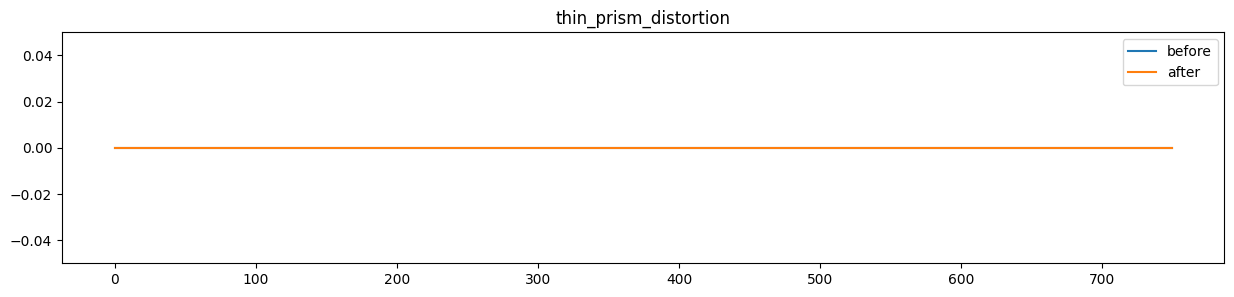

In [16]:
# plot each key in indCamParams in a subplot

for key in correctedIndCamParams.keys():
    correctedValues2d = correctedIndCamParams[key]
    originalValues2d = indCamParamsOrig[key]
    if len(correctedValues2d.shape) == 1:
        correctedValues2d = np.array([correctedValues2d])
        originalValues2d = np.array([originalValues2d])
    else:
        correctedValues2d = correctedValues2d.T
        originalValues2d = originalValues2d.T
    
    for correctedValues1d, originalValues1d in zip(correctedValues2d, originalValues2d):
        plt.figure(figsize=(15, 3))
        plt.plot(originalValues1d)
        plt.plot(correctedValues1d)
        plt.legend(["before", "after"])
        plt.title(key)
        plt.ylim(np.min(correctedValues1d), np.max(correctedValues1d))
        plt.show()

In [17]:
# rep_errors = indCamParams["rep_err"]
# # count the number of rep_error whose value is greater than 15
# print("Number of rep_error greater than 15:", np.sum(rep_errors > 10))

### Smoothing of the camera parameters using savgol filter

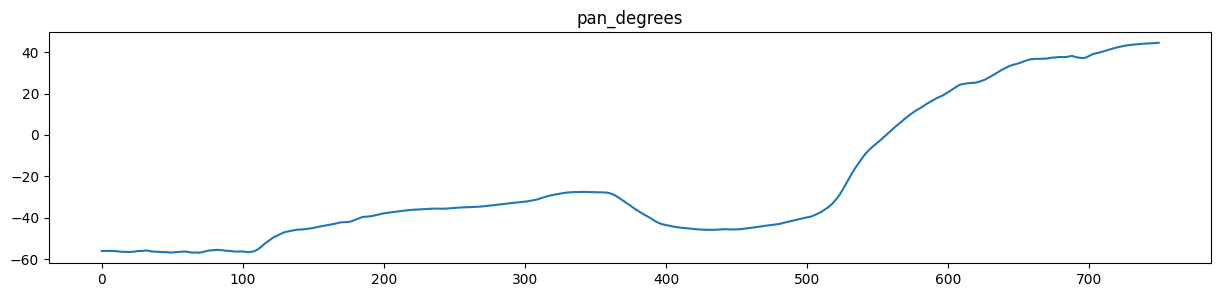

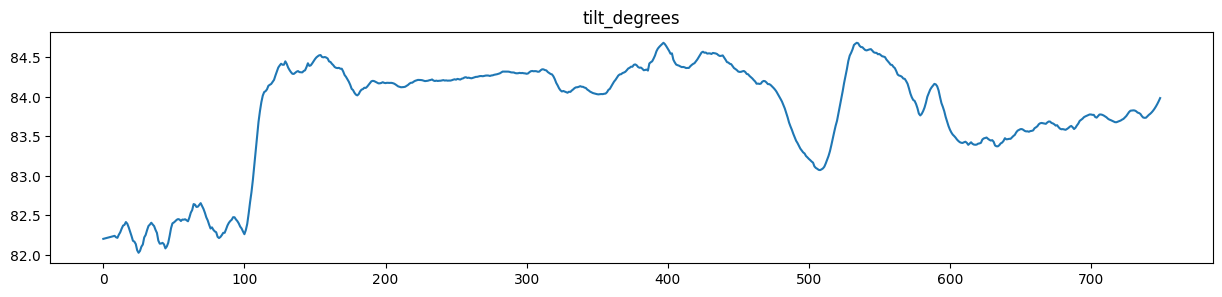

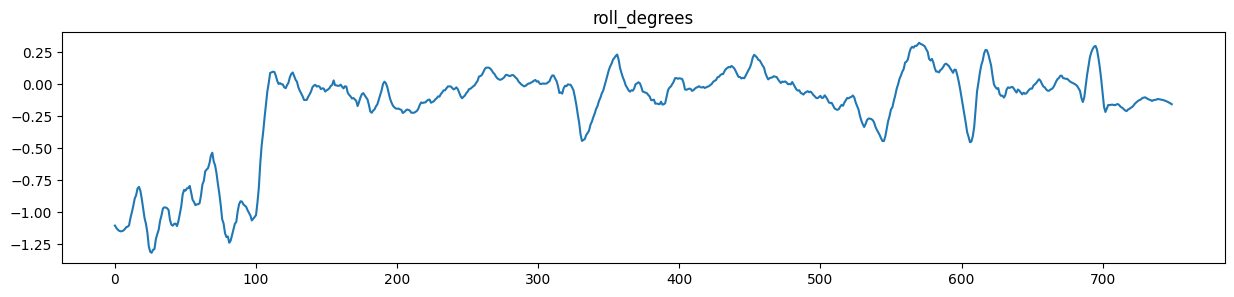

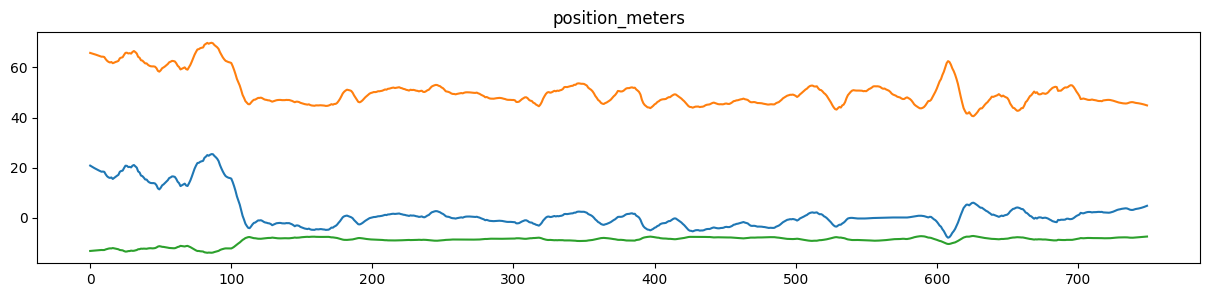

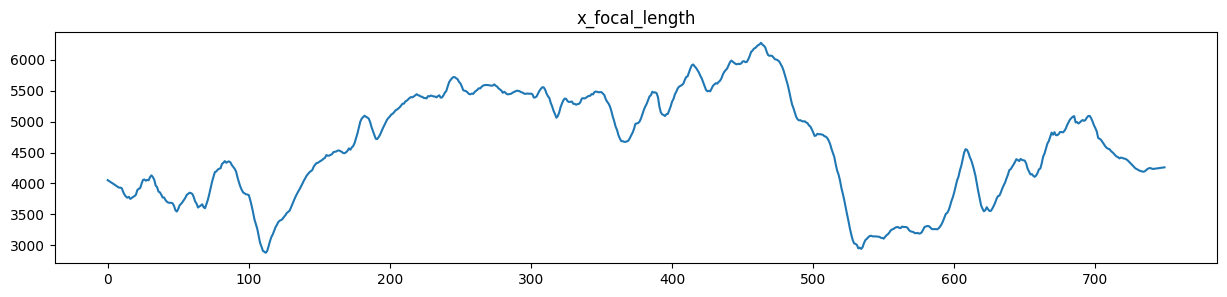

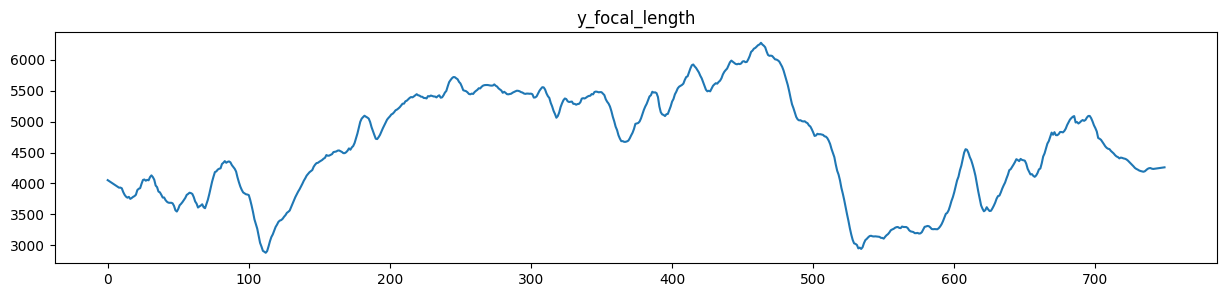

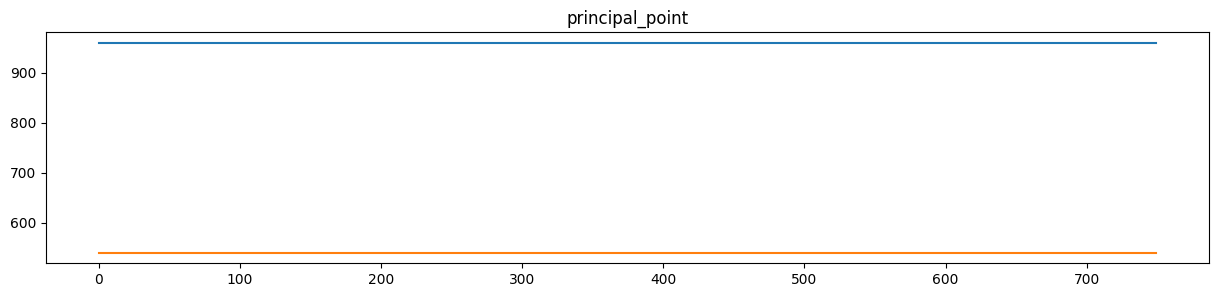

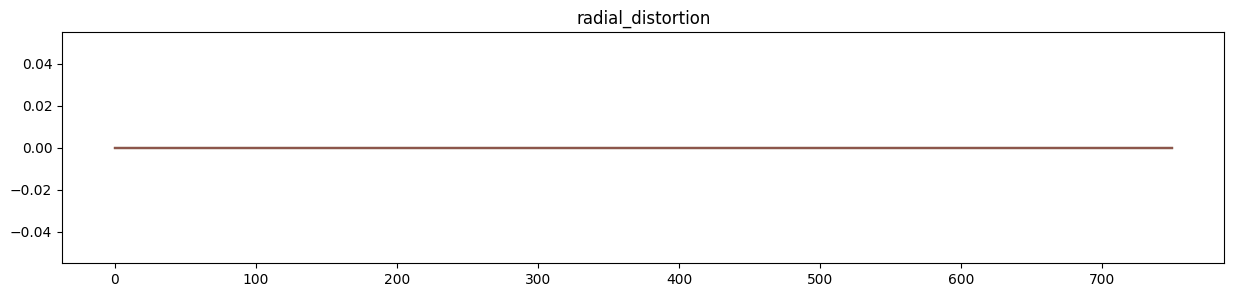

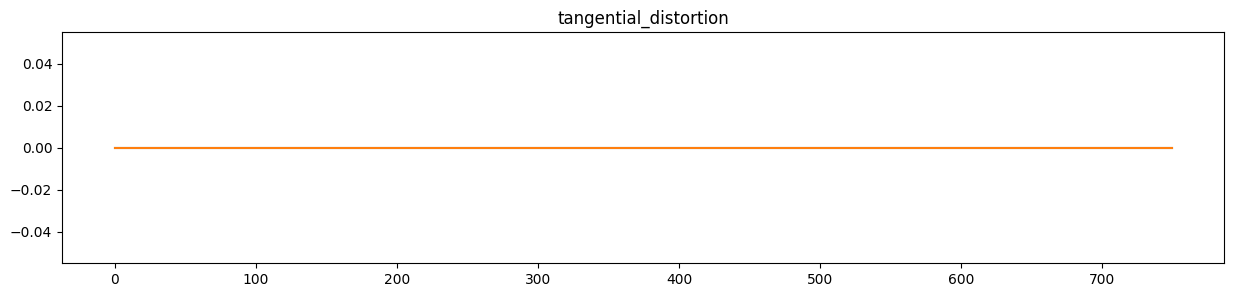

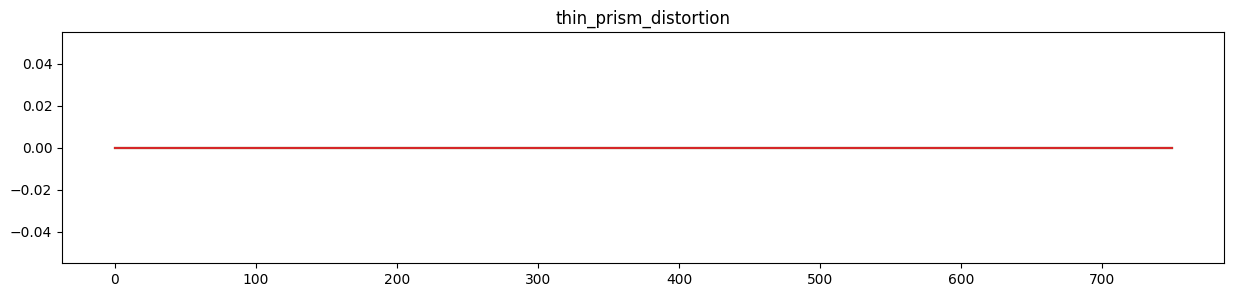

In [18]:
smoothedIndCamParams = deepcopy(correctedIndCamParams)
for key in correctedIndCamParams.keys():
    smoothedIndCamParams[key] = savgol_filter(correctedIndCamParams[key], 17, 2, axis=0)
# clamp values of radial_distortion, tangential_distortion and thin_prism_distortion btw 0 and +inf
for key in ["radial_distortion", "tangential_distortion", "thin_prism_distortion"]:
    smoothedIndCamParams[key] = np.maximum(smoothedIndCamParams[key], 0)
for key in smoothedIndCamParams.keys():
    plt.figure(figsize=(15, 3))
    plt.plot(smoothedIndCamParams[key])
    # plt.plot(savgol_filter(smoothedIndCamParams[key], 25, 2, axis=0, deriv=1))
    # print(max(savgol_filter(smoothedIndCamParams[key], 25, 2, axis=0, deriv=1)))
    plt.title(key)
    plt.show()

In [19]:
smoothedCamParams = [dict(zip(smoothedIndCamParams.keys(), [smoothedIndCamParams[key][i] for key in smoothedIndCamParams.keys()])) for i in range(len(camParams))]

## Semantic segmentation masks filtering

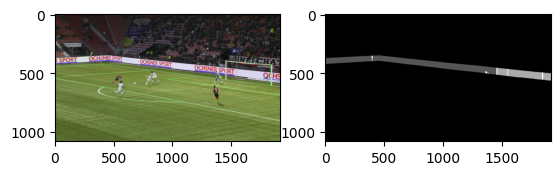

In [20]:
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 700

img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.png')
# smoothedCamParams[imgNum - 1]['roll_degrees'] = 0
cam.from_json_parameters(smoothedCamParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
imgWithLines = deepcopy(img)
imgWithLines = cam.draw_pitch(cam.draw_corners(imgWithLines))
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)

# remove first 360 lines of img and mask
# imgWithLines = imgWithLines[360:]
# mask = mask[360:]

# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imgWithLines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

In [21]:
smoothedCamParams[imgNum - 1]

{'pan_degrees': 37.84306818460317,
 'tilt_degrees': 83.77849416734391,
 'roll_degrees': 0.03776320139560682,
 'position_meters': array([ 0.77595685, 50.39019259, -8.41964198]),
 'x_focal_length': 4941.234608345935,
 'y_focal_length': 4941.234608345935,
 'principal_point': array([960., 540.]),
 'radial_distortion': array([0., 0., 0., 0., 0., 0.]),
 'tangential_distortion': array([0., 0.]),
 'thin_prism_distortion': array([0., 0., 0., 0.])}

### Keep biggest blob in the mask

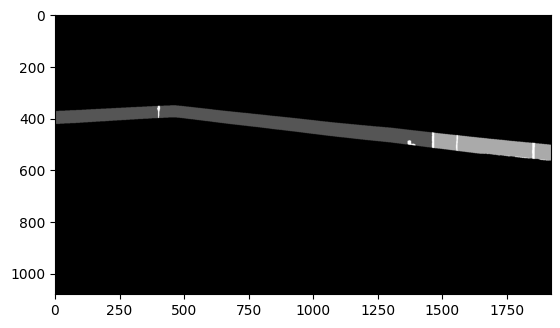

In [22]:
# plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')

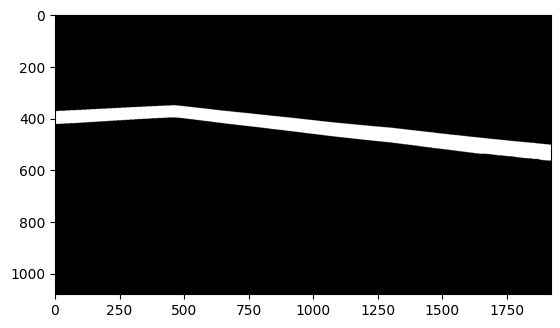

In [23]:
# find the blob with the largest area. Another option might be to find the blob with the largest perimeter. The second solution is below in the commented code
# contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# largest_contour = max(contours, key=len)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
biggestBloBMask = np.zeros(mask.shape, np.uint8)
cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
# mask = biggestBloBMask
plt.imshow(biggestBloBMask.astype(np.bool_).astype(np.float32), cmap='gray')

In [24]:
mask.dtype, mask.shape, biggestBloBMask.dtype, biggestBloBMask.shape

(dtype('uint8'), (1080, 1920), dtype('uint8'), (1080, 1920))

In [25]:
np.unique(mask), np.unique(biggestBloBMask.astype(np.bool_))

(array([0, 1, 2, 3], dtype=uint8), array([False,  True]))

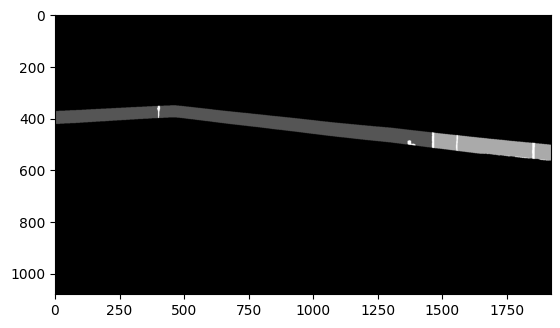

In [26]:
# fill with zeros the mask outside the biggest blob
tmp = cv2.bitwise_and(mask, biggestBloBMask)
plt.imshow(tmp, cmap='gray')

In [27]:
mask = biggestBloBMask

### Compute corner position

Euristic: There is always at most one corner in the image and it is located at the topest point in the non-zero pixels of the mask.
!!! Only for the top left and right corners !!!

In [28]:
binMask = np.uint8(mask > 0)
firstNonZeroIdx = np.argmax(binMask, axis=0)
colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
flipped = cv2.flip(binMask, 0) # type: ignore
flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
colsWithNonZero = np.intersect1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
# colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1

In [29]:
mask.shape[0]

1080

[655 656 656 ... 514 513 513]
(1920,) (1920,)


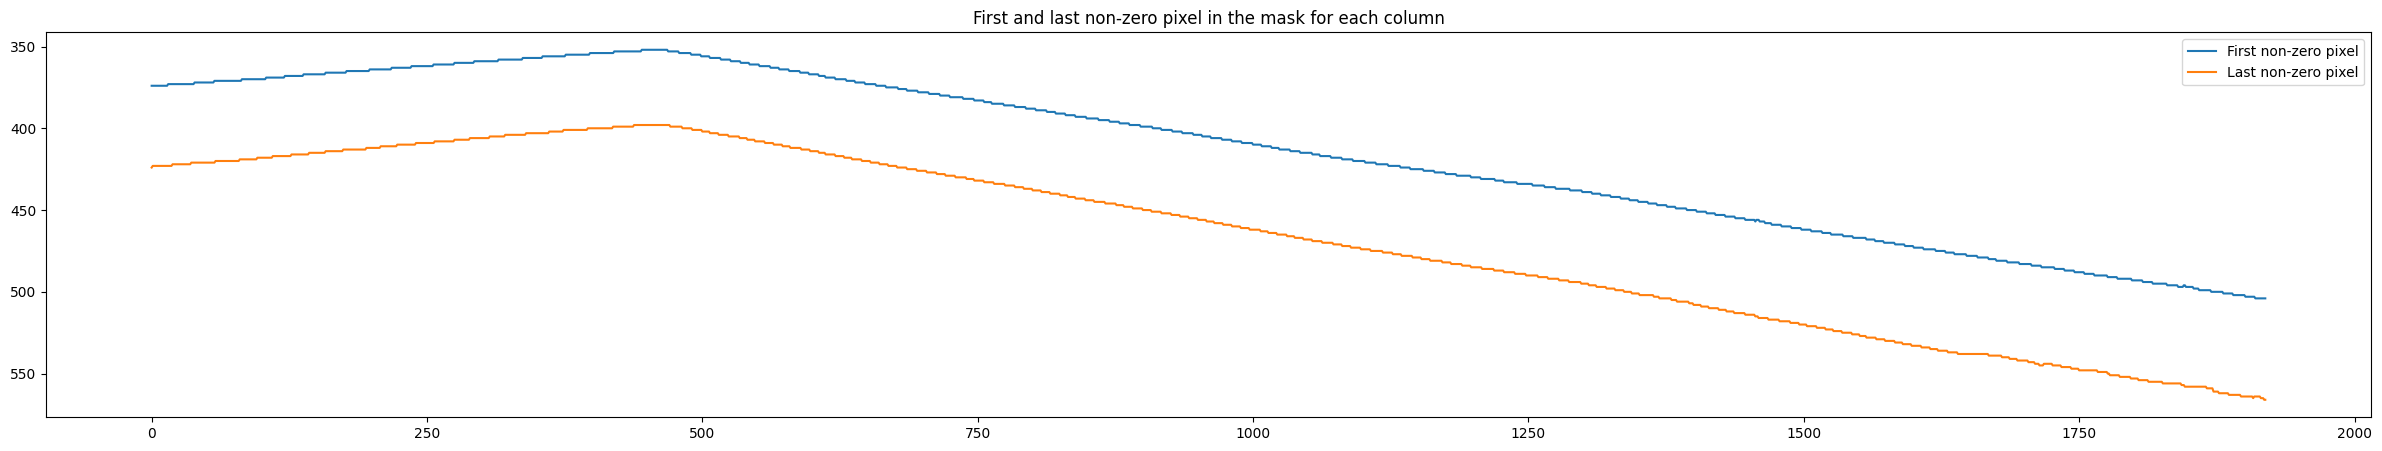

In [30]:
binMask = np.uint8(mask > 0)
firstNonZeroIdx = np.argmax(binMask, axis=0)
colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
flipped = cv2.flip(binMask, 0) # type: ignore
flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
print(flippedLastNonZeroIdx)
# colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
colsWithNonZero = np.intersect1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
# colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
print(firstNonZeroIdx.shape, lastNonZeroIdx.shape)

plt.figure(figsize=(30, 5))
# flip y axis
plt.gca().invert_yaxis()
plt.plot(colsWithNonZero, firstNonZeroIdx)
plt.plot(colsWithNonZero, lastNonZeroIdx)
plt.title("First and last non-zero pixel in the mask for each column")
plt.legend(["First non-zero pixel", "Last non-zero pixel"])
plt.show()

In [31]:
colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]

array([445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468])

In [32]:
colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int)

456

In [33]:
tmp = np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)
print(tmp)
print(lastNonZeroIdx[tmp])
pixel = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int), lastNonZeroIdx[tmp]])
pixel

456
398


array([456, 398])

In [34]:
cols = colsWithNonZero[lastNonZeroIdx == np.min(lastNonZeroIdx)]
cols

array([438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470])

In [35]:
# check that cols is an array of consecutive integers
# If that is not the case, it means we are in the case where two sides (for example middle and right)
# of the banner are visible in the image but not the corner at their intersection.
# Note that, with the "keep biggest blob" filtering, this case should not happen since, if the corner is not visible
# but the two sides are, then there is two blobs and the biggest one is kept.
# But in case this filtering is not applied because it is more harmful than useful, we need to handle this case.
if np.all(np.diff(cols) == 1):
    # The corner is in the image
    pixelX = cols.mean().round().astype(int)
    print(pixelX)
    pixelY = lastNonZeroIdx[np.where(colsWithNonZero == pixelX)[0][0]]
    print(pixelX, pixelY)
else:
    # The corner is not in the image
    pixel = np.zeros(2, dtype=np.int32)

454
454 398


In [36]:
# Check is one of the colums [i in range(5)] is in cols
np.any([i in cols for i in range(5)])

False

In [37]:
cam.unproject_point_on_planeZ0(pixel)[:2]

array([ 56.87402618, -39.37107519])

In [38]:
np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])

array([456, 398])

In [39]:
cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(pixel)[:2]
cornerCoordX, cornerCoordY

(56.87402618284048, -39.37107519478871)

In [40]:
cam.project_point(np.array([cornerCoordX, cornerCoordY, 0]))

array([456.0000066 , 397.99999879,   1.        ])

In [41]:
import cv2 as cv

In [42]:
Xworld = np.array([[cornerCoordX, cornerCoordY, 0], [cornerCoordX, cornerCoordY, -1]], dtype=np.float32)
# cam.from_json_parameters(smoothedCamParams[imgNum - 1])
# project points using opencv cv.projectPoints
objectPoints = np.array(Xworld)
print(objectPoints)
R = cam.rotation
c = cam.position
rvec = cv2.Rodrigues(R)[0]
tvec = -R @ c.reshape(-1, 1)
# print(rvec, tvec)
cameraMatrix = cam.calibration
distCoeffs = np.zeros((4, 1))
cv.projectPoints(objectPoints, rvec, tvec, cameraMatrix, distCoeffs)[0]

[[ 56.874027 -39.371075   0.      ]
 [ 56.874027 -39.371075  -1.      ]]


array([[[456.00006, 398.     ]],

       [[455.45157, 351.2866 ]]], dtype=float32)

In [43]:
# objectPt = np.array([456, 398, 0, 1])
# P = cam.get_projection()
# print(P)
# imagePt = P @ objectPt
# imagePt /= imagePt[2]
# imagePt

In [44]:
# imagePt = np.array([cornerCoordX, cornerCoordY])
# imagePt = np.append(imagePt, 1)
# print(imagePt)
# H = cam.to_homography()
# Hinv = np.linalg.inv(H)
# pitchPt = Hinv @ imagePt
# print(pitchPt)
# pitchPt = pitchPt / pitchPt[2]
# pitchPt

56.87402618284048 -39.37107519478871
True False True


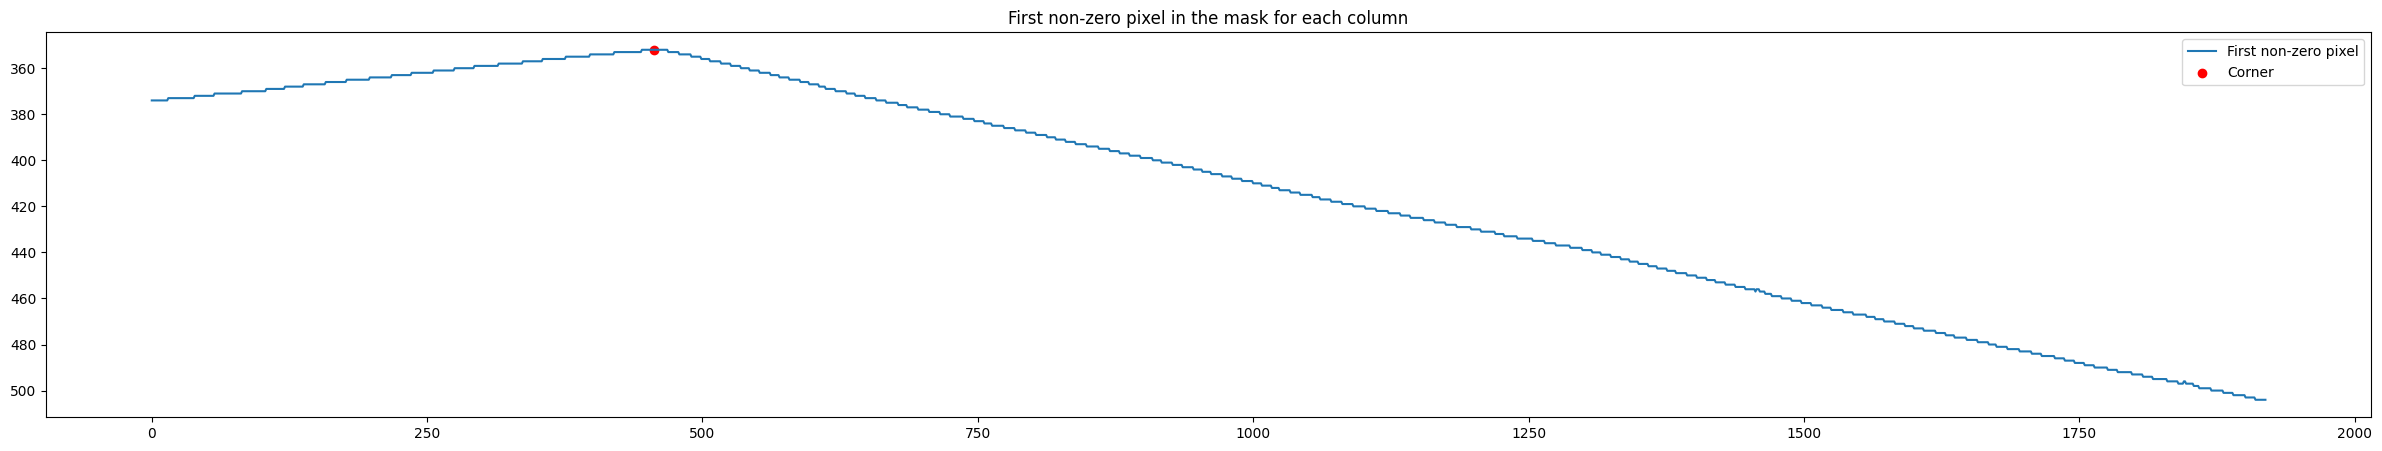

cornerCol: 456


In [45]:
cornerCol = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int)
cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(pixel)[:2]
print(cornerCoordX, cornerCoordY)
print(cornerCoordY < -68/2, cornerCoordX < -105/2, cornerCoordX > 105/2)
if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
    plt.figure(figsize=(30, 5))
    plt.gca().invert_yaxis()
    plt.plot(colsWithNonZero, firstNonZeroIdx)
    plt.scatter(cornerCol, np.min(firstNonZeroIdx), color='red')
    plt.title("First non-zero pixel in the mask for each column")
    plt.legend(["First non-zero pixel", "Corner"])
    plt.show()
print('cornerCol:', cornerCol)

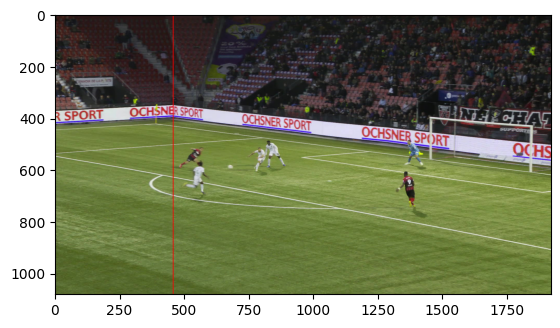

In [46]:
# draw a vertical line at the corner column on the image
imgWithCornerLine = deepcopy(img)
if cornerCol != -1:
    cv2.line(imgWithCornerLine, (cornerCol, 0), (cornerCol, img.shape[0]), (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(imgWithCornerLine, cv2.COLOR_BGR2RGB))

Taking into account distorsions to compute the banner model parameters seems to reduce the error in the final result. (std is reduced and std of the error is thus reduced)

To compute the banner distance to the pitch field edge, the mean of the mean of each image is computed instead of the mean of every image column of all images. This seems to reduce (a bit) the std (error). However the height is still computed using the mean of the columns.
! Need to check usign other videos what is the best way to the banner model parameters !

2 solutions to compte the banner model dist parameters:
- Using only the points in the "soccer field dimensions", thus not the points close to the banner corners since they are not 100% reliable.
- Using all the points in the image.

Need to check which one is the best. It seems that in terms of std the first solution is better. But the banner corner position is still quite reliable so why not use it ?

In [47]:
heights = np.zeros(750 * 1920, dtype=np.float64)
heightsArrayLen = 0

bannersDims = dict()
sides = ['left', 'middle', 'right']
for side in sides:
    bannersDims[side] = dict()
    bannersDims[side]['distArray'] = np.zeros(750, dtype=np.float64)
    bannersDims[side]['distArray'][:] = np.nan
    bannersDims[side]['warpDistArray'] = np.zeros(750, dtype=np.float64)
    bannersDims[side]['warpDistArray'][:] = np.nan
for i in ['leftCorner', 'rightCorner']:
    bannersDims[i] = dict()
    bannersDims[i]['pt2Darray']	= np.zeros((750, 2), dtype=np.float64)
    bannersDims[i]['pt2Darray'][:] = np.nan
bannersDims['heightArray'] = np.zeros(750, dtype=np.float64)
bannersDims['warpHeightArray'] = np.zeros(750, dtype=np.float64)
bannersDims['colsWithNonZero'] = np.zeros(750, dtype=np.object_)  #! Not used
bannersDims['firstNonZeroIdx'] = np.zeros(750, dtype=np.object_)  #! Not used
bannersDims['lastNonZeroIdx'] = np.zeros(750, dtype=np.object_)  #! Not used
# stats = dict()
# for side in sides:
# 	stats[side] = dict()
# 	stats[side]['mean'] = np.zeros(750, dtype=np.float64)
# 	stats[side]['mean'][:] = np.nan
# 	stats[side]['std'] = np.zeros(750, dtype=np.float64)
# 	stats[side]['std'][:] = np.nan

# for i in tqdm(range(749,750)):
for i in tqdm(range(750)):
    cam.from_json_parameters(smoothedCamParams[i])
    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
    binMask = np.uint8(mask > 0)
    contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    biggestBloBMask = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
    mask = biggestBloBMask
    binMask = np.uint8(mask > 0)
    firstNonZeroIdx = np.argmax(binMask, axis=0)
    colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
    flipped = cv2.flip(binMask, 0)
    flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
    colsWithNonZero = np.intersect1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
    # colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
    bannersDims['colsWithNonZero'][i] = colsWithNonZero
    firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
    bannersDims['firstNonZeroIdx'][i] = firstNonZeroIdx
    flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
    lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
    bannersDims['lastNonZeroIdx'][i] = lastNonZeroIdx
    points2D = np.array([[x, y] for x, y in zip(colsWithNonZero, lastNonZeroIdx)])
    unprojectedPoints = np.array([cam.unproject_point_on_planeZ0(p, undistort=True) for p in points2D])
    unprojectedPoints[:, 2] = -1
    z1m = [cam.project_point(p, distort=True)[1] for p in unprojectedPoints]
    realz = (lastNonZeroIdx - firstNonZeroIdx) / (lastNonZeroIdx - z1m)
    bannersDims['heightArray'] = realz.mean()
    bannersDims['warpHeightArray'][i] = realz.max()
    heights[heightsArrayLen:heightsArrayLen + realz.shape[0]] = realz
    heightsArrayLen += realz.shape[0]

    cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
    cornerCol = cornerCols.mean().round().astype(int)
    point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
    cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
    if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
        # Then the corner is valid and 2 sides are visible on the image
        if cornerCoordX < 0:
            bannersDims['leftCorner']['pt2Darray'][i] = point2D.round().astype(int)
            # The left and middle sides are visible
            cond = colsWithNonZero < cornerCol
            bannersDims['left']['distArray'][i] = unprojectedPoints[cond][:, 0].mean()
            bannersDims['left']['warpDistArray'][i] = unprojectedPoints[cond][:, 0].min()
            bannersDims['middle']['distArray'][i] = unprojectedPoints[~cond][:, 1].mean()
            bannersDims['middle']['warpDistArray'][i] = unprojectedPoints[~cond][:, 1].min()
        else:
            bannersDims['rightCorner']['pt2Darray'][i] = point2D.round().astype(int)
            # The middle and right sides are visible
            cond = colsWithNonZero > cornerCol
            bannersDims['right']['distArray'][i] = unprojectedPoints[cond][:, 0].mean()
            bannersDims['right']['warpDistArray'][i] = unprojectedPoints[cond][:, 0].min()
            bannersDims['middle']['distArray'][i] = unprojectedPoints[~cond][:, 1].mean()
            bannersDims['middle']['warpDistArray'][i] = unprojectedPoints[~cond][:, 1].min()
    else:
        # Only one side is visible on the image
        y = unprojectedPoints[:, 1].mean()
        if y < -68/2:
            # The middle side is visible
            bannersDims['middle']['distArray'][i] = unprojectedPoints[:, 1].mean()
            bannersDims['middle']['warpDistArray'][i] = unprojectedPoints[:, 1].min()
        else:
            # The left or right side is visible
            x = unprojectedPoints[:, 0].mean()
            xmin = unprojectedPoints[:, 0].min()
            if x < 0:
                # The left side is visible
                bannersDims['left']['distArray'][i] = x
                bannersDims['left']['warpDistArray'][i] = xmin
            else:
                # The right side is visible
                bannersDims['right']['distArray'][i] = x
                bannersDims['right']['warpDistArray'][i] = xmin



    # for side in sides:
    # 	if side == 'middle':
    # 		pts = np.bitwise_and(unprojectedPoints[:, 0] >= -105/2, unprojectedPoints[:, 0] <= 105/2)
    # 		pts = unprojectedPoints[pts][:, 1]
    # 		if pts.shape[0] == 0:
    # 			continue
    # 		bannersDims[side]['distArray'][i] = pts.mean()
    # 	else:
    # 		pts = np.bitwise_and(unprojectedPoints[:, 1] >= -68/2, unprojectedPoints[:, 1] <= 68/2)
    # 		pts = np.bitwise_and(pts, unprojectedPoints[:, 0] < 0 if side == 'left' else unprojectedPoints[:, 0] > 0)
    # 		pts = unprojectedPoints[pts][:, 0]
    # 		if pts.shape[0] == 0:
    # 			continue
    # 		bannersDims[side]['distArray'][i] = pts.mean()

100%|██████████| 750/750 [01:53<00:00,  6.62it/s]


In [48]:
heights = heights[:heightsArrayLen]
height = np.mean(heights)
np.mean(heights), np.std(heights)

(0.9665693981475446, 0.030047981231023427)

In [49]:
for side in sides:
    # bannersDims[side]['distArray'] = bannersDims[side]['distArray'][:bannersDims[side]['distArrayLen']]
    # bannersDims[side]['dist'] = np.mean(bannersDims[side]['distArray'])
    bannersDims[side]['dist'] = np.nanmean(bannersDims[side]['distArray'])
    print(side, bannersDims[side]['dist'], np.nanstd(bannersDims[side]['distArray']))

left -57.023159087413134 0.2842134345263028
middle -38.783102446637336 1.0830629544789439
right 57.121379372977415 0.2704762706594519


In [50]:
for side in sides:
    if side == 'middle':
        leftx = bannersDims['left']['dist']
        rightx = bannersDims['right']['dist']
        y = bannersDims['middle']['dist']
        bannersDims[side]['pts3D'] = np.array([[leftx, y, 0], [leftx, y, -height], [rightx, y, -height], [rightx, y, 0]])
    else:
        x = bannersDims[side]['dist']
        y = bannersDims['middle']['dist']
        if side == 'right':
            y = -y
        bannersDims[side]['pts3D'] = np.array([[x, -y, 0], [x, -y, -height], [x, y, -height], [x, y, 0]])
    print(side, bannersDims[side]['pts3D'])

left [[-57.02315909  38.78310245   0.        ]
 [-57.02315909  38.78310245  -0.9665694 ]
 [-57.02315909 -38.78310245  -0.9665694 ]
 [-57.02315909 -38.78310245   0.        ]]
middle [[-57.02315909 -38.78310245   0.        ]
 [-57.02315909 -38.78310245  -0.9665694 ]
 [ 57.12137937 -38.78310245  -0.9665694 ]
 [ 57.12137937 -38.78310245   0.        ]]
right [[ 57.12137937 -38.78310245   0.        ]
 [ 57.12137937 -38.78310245  -0.9665694 ]
 [ 57.12137937  38.78310245  -0.9665694 ]
 [ 57.12137937  38.78310245   0.        ]]


In [51]:
# cv2.namedWindow('image')
# cv2.moveWindow('image', 30, 40)

# imgWithBanners = deepcopy(img)

# for i in range(750):
# 	imgWithBanners = cv2.imread(imgPath + str(i).zfill(6) + '.png')
# 	cam.from_json_parameters(smoothedCamParams[i])
# 	for side in sides:
# 		pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
# 		pts2D[1][0] = pts2D[0][0]
# 		pts2D[2][0] = pts2D[3][0]
# 		if np.any(pts2D == 0):  # pts are not in the image
# 			continue
# 		cv2.polylines(imgWithBanners, [pts2D.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
# 	# cam.draw_pitch(imgWithBanners)
# 	# cam.draw_corners(imgWithBanners)
# 	cv2.imshow('image', imgWithBanners)
# 	cv2.waitKey(20)

# cv2.destroyAllWindows()

In [52]:
# # Credits: https://github.com/SoccerNet/sn-gamestate/blob/main/plugins/calibration/sn_calibration_baseline/camera.py

# def rotation_matrix_to_pan_tilt_roll(rotation):
#     """
#     Decomposes the rotation matrix into pan, tilt and roll angles. There are two solutions, but as we know that cameramen
#     try to minimize roll, we take the solution with the smallest roll.
#     :param rotation: rotation matrix
#     :return: pan, tilt and roll in radians
#     """
#     orientation = np.transpose(rotation)
#     first_tilt = np.arccos(orientation[2, 2])
#     second_tilt = - first_tilt

#     sign_first_tilt = 1. if np.sin(first_tilt) > 0. else -1.
#     sign_second_tilt = 1. if np.sin(second_tilt) > 0. else -1.

#     first_pan = np.arctan2(sign_first_tilt * orientation[0, 2], sign_first_tilt * - orientation[1, 2])
#     second_pan = np.arctan2(sign_second_tilt * orientation[0, 2], sign_second_tilt * - orientation[1, 2])
#     first_roll = np.arctan2(sign_first_tilt * orientation[2, 0], sign_first_tilt * orientation[2, 1])
#     second_roll = np.arctan2(sign_second_tilt * orientation[2, 0], sign_second_tilt * orientation[2, 1])

#     # print(f"first solution {first_pan*180./np.pi}, {first_tilt*180./np.pi}, {first_roll*180./np.pi}")
#     # print(f"second solution {second_pan*180./np.pi}, {second_tilt*180./np.pi}, {second_roll*180./np.pi}")
#     if np.fabs(first_roll) < np.fabs(second_roll):
#         return first_pan, first_tilt, first_roll
#     return second_pan, second_tilt, second_roll

# def pan_tilt_roll_to_orientation(pan, tilt, roll):
#     """
#     Conversion from euler angles to orientation matrix.
#     :param pan:
#     :param tilt:
#     :param roll:
#     :return: orientation matrix
#     """
#     Rpan = np.array([
#         [np.cos(pan), -np.sin(pan), 0],
#         [np.sin(pan), np.cos(pan), 0],
#         [0, 0, 1]])
#     Rroll = np.array([
#         [np.cos(roll), -np.sin(roll), 0],
#         [np.sin(roll), np.cos(roll), 0],
#         [0, 0, 1]])
#     Rtilt = np.array([
#         [1, 0, 0],
#         [0, np.cos(tilt), np.sin(tilt)],
#         [0, -np.sin(tilt), np.cos(tilt)]])
#     # rotMat = np.dot(Rpan, np.dot(Rtilt, Rroll))
#     rotMat = np.dot(Rroll, np.dot(Rtilt, Rpan))
#     return rotMat

In [53]:
cv2.namedWindow('image')
cv2.moveWindow('image', 30, 40)

imgNum = 700
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.png')
tmpImg = deepcopy(img)
cam.from_json_parameters(smoothedCamParams[imgNum])
# cam.from_json_parameters(testCamParam)

for side in sides:
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
    pts2D[1][0] = pts2D[0][0]
    pts2D[2][0] = pts2D[3][0]
    if np.any(pts2D == 0):  # pts are not in the image
        continue
    cv2.polylines(tmpImg, [pts2D.round().astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=1)

corner2D = bannersDims['leftCorner']['pt2Darray'][imgNum].copy()
cornerType = 'no corner'
if not np.any(np.isnan(corner2D)):
    # Left corner present in the image
    cornerType = 'left corner'
else:
    corner2D = bannersDims['rightCorner']['pt2Darray'][imgNum].copy()
    if not np.any(np.isnan(corner2D)):
        # Right corner present in the image
        cornerType = 'right corner'

if cornerType == 'left corner':
    print(corner2D)
    cv2.circle(tmpImg, corner2D.astype(np.int32), 1, (0, 0, 255), -1)
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims['middle']['pts3D']])
    diff = corner2D - pts2D[0]
    for side in sides:
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        if np.any(pts2D == 0):  # pts are not in the image
            continue
        pts2D += diff
        cv2.polylines(tmpImg, [pts2D.round().astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)
    pts3D = bannersDims['middle']['pts3D']
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
    pts2D[1][0] = pts2D[0][0]
    pts2D[2][0] = pts2D[3][0]
    objectPoints = pts3D.copy()
    imagePoints = pts2D.copy()
    pts3D = bannersDims['left']['pts3D']
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
    pts2D[1][0] = pts2D[0][0]
    pts2D[2][0] = pts2D[3][0]
    objectPoints = np.concatenate((objectPoints, pts3D))
    imagePoints = np.concatenate((imagePoints, pts2D))
    imagePoints += diff

elif cornerType == 'right corner':
    print(corner2D)
    cv2.circle(tmpImg, corner2D.astype(np.int32), 5, (0, 255, 0), -1)
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims['middle']['pts3D']])
    diff = corner2D - pts2D[3]
    for side in sides:
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        if np.any(pts2D == 0):  # pts are not in the image
            continue
        pts2D += diff
        cv2.polylines(tmpImg, [pts2D.round().astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)
    pts3D = bannersDims['middle']['pts3D']
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
    pts2D[1][0] = pts2D[0][0]
    pts2D[2][0] = pts2D[3][0]
    objectPoints = pts3D.copy()
    imagePoints = pts2D.copy()
    pts3D = bannersDims['right']['pts3D']
    pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
    pts2D[1][0] = pts2D[0][0]
    pts2D[2][0] = pts2D[3][0]
    objectPoints = np.concatenate((objectPoints, pts3D))
    imagePoints = np.concatenate((imagePoints, pts2D))
    imagePoints += diff

if cornerType != 'no corner':
    print(objectPoints)
    # set of object points
    # print(len(set([tuple(p) for p in objectPoints])))
    # objectPoints = np.array(list(set([tuple(p) for p in objectPoints])))
    # print(objectPoints)
    print(imagePoints)
    # imagePoints = np.array(list(set([tuple(p) for p in imagePoints])))
    print(cam.to_json_parameters())
    cameraMatrix = np.array(cam.calibration, dtype=np.float64)
    # ret, rvec, tvec = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, None, flags=cv2.SOLVEPNP_SQPNP) # type: ignore
    R = cam.rotation
    c = cam.position
    rvec = cv2.Rodrigues(R)[0]
    tvec = -R @ c.reshape(-1, 1) # type: ignore
    rvec, tvec = cv2.solvePnPRefineLM(objectPoints, imagePoints, cameraMatrix, None, rvec, tvec) # type: ignore
    reprojection_error, _ = cv2.projectPoints(objectPoints, rvec, tvec, cameraMatrix, None) # type: ignore
    reprojection_error = np.linalg.norm(imagePoints - reprojection_error)
    print('reprojection_error:', reprojection_error)
    
    rotation, _ = cv2.Rodrigues(rvec)
    position = - np.transpose(rotation) @ tvec.flatten()
    pan, tilt, roll = rotation_matrix_to_pan_tilt_roll(rotation)
    if -np.pi/2 > pan or pan > np.pi/2:
        dpi = -np.sign(pan) * np.pi
        pan += dpi
        roll *=-1
        position[2] *= -1
    rotation = np.transpose(pan_tilt_roll_to_orientation(pan, tilt, roll))
    print(np.array(rotation_matrix_to_pan_tilt_roll(rotation)) * 180 / np.pi)
    print('position:', position)
    cam.position = position
    cam.rotation = rotation
    print(cam.to_json_parameters())

# cv2.imshow('image', tmpImg)
# cv2.waitKey(0)

cv2.destroyAllWindows()

[448. 398.]
[[-57.02315909 -38.78310245   0.        ]
 [-57.02315909 -38.78310245  -0.9665694 ]
 [ 57.12137937 -38.78310245  -0.9665694 ]
 [ 57.12137937 -38.78310245   0.        ]
 [ 57.12137937 -38.78310245   0.        ]
 [ 57.12137937 -38.78310245  -0.9665694 ]
 [ 57.12137937  38.78310245  -0.9665694 ]
 [ 57.12137937  38.78310245   0.        ]]
[[-13379.48869113   1185.46519534]
 [-13379.48869113   1049.78638787]
 [   448.            352.76904511]
 [   448.            398.        ]
 [   448.            398.        ]
 [   448.            352.76904511]
 [  5119.68361156    839.68471488]
 [  5119.68361156    946.29807947]]
{'pan_degrees': 38.189850124390276, 'tilt_degrees': 83.77854452380987, 'roll_degrees': -0.06657176723399545, 'position_meters': [1.0315880520117824, 49.599030462365256, -8.325317982780657], 'x_focal_length': 4895.552335547646, 'y_focal_length': 4895.552335547646, 'principal_point': [959.9999999999955, 539.9999999999973], 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 

In [54]:
# import numpy as np
# from tqdm import tqdm
# import cv2
# from multiprocessing import Pool


# def compute_banner_model_params(
#     camParamsPerImage_, maskPath_, imgWidth_, imgHeight_, nWorkers, nFrames
# ):
#     global camParamsPerImage, maskPath, imgWidth, imgHeight
#     camParamsPerImage = camParamsPerImage_
#     maskPath = maskPath_
#     imgWidth = imgWidth_
#     imgHeight = imgHeight_

#     with Pool(nWorkers) as p:
#         res = list(
#             tqdm(
#                 p.imap(compute_banner_model_params_worker, range(nFrames)),
#                 total=nFrames,
#             )
#         )
#     bannersObjPts = np.nanmean(np.array([r["bannersDims"] for r in res]), axis=0)
#     bannerHeight, leftBannerDist, middleBannerDist, rightBannerDist = bannersObjPts
#     sides = ["left", "middle", "right"]
#     bannersObjPts = dict()
#     for side in sides:
#         if side == "middle":
#             leftx = leftBannerDist
#             rightx = rightBannerDist
#             y = middleBannerDist
#             bannersObjPts[side] = np.array(
#                 [
#                     [leftx, y, 0],
#                     [leftx, y, -bannerHeight],
#                     [rightx, y, -bannerHeight],
#                     [rightx, y, 0],
#                 ]
#             )
#         else:
#             x = leftBannerDist if side == "left" else rightBannerDist
#             y = middleBannerDist
#             if side == "right":
#                 y = -y
#             bannersObjPts[side] = np.array(
#                 [[x, -y, 0], [x, -y, -bannerHeight], [x, y, -bannerHeight], [x, y, 0]]
#             )
#     LeftCornerImgPtPerImage = np.array([r["corners"][0] for r in res])
#     RightCornerImgPtPerImage = np.array([r["corners"][1] for r in res])
#     return bannersObjPts, LeftCornerImgPtPerImage, RightCornerImgPtPerImage


# def compute_banner_model_params_worker(i):
#     cam = Camera()
#     cam.from_json_parameters(camParamsPerImage[i])
#     binMask = (
#         cv2.imread(
#             maskPath + "filtered_" + str(i).zfill(6) + ".png", cv2.IMREAD_GRAYSCALE
#         )
#         .__gt__(0)  # type: ignore
#         .astype(np.uint8)
#     )
#     firstNonZeroIdx = np.argmax(binMask, axis=0)
#     colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
#     flipped = cv2.flip(binMask, 0)
#     flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
#     # colsWithNonZero is the set of columns that have two non-zero pixels
#     # and the non-zero pixels are not at the top or bottom of the image
#     colsWithNonZero = np.intersect1d(
#         colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0]
#     )
#     firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
#     flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
#     lastNonZeroIdx = imgHeight - flippedLastNonZeroIdx - 1
#     imgPts = np.array([[x, y] for x, y in zip(colsWithNonZero, lastNonZeroIdx)])
#     objPts = np.array(
#         [cam.unproject_point_on_planeZ0(p, undistort=False) for p in imgPts]
#     )
#     objPts[:, 2] = -1
#     R, c, cameraMatrix = cam.rotation, cam.position, cam.calibration
#     rvec = cv2.Rodrigues(R)[0]
#     tvec = -R @ c.reshape(-1, 1)  # type: ignore
#     z1m = cv2.projectPoints(objPts, rvec, tvec, cameraMatrix, np.zeros(4))[0][:, 0, 1]
#     realZ = (lastNonZeroIdx - firstNonZeroIdx) / (lastNonZeroIdx - z1m)
#     bannerHeight = realZ.mean()

#     cornerCols = colsWithNonZero[lastNonZeroIdx == np.min(lastNonZeroIdx)]
#     # check that cols is an array of consecutive integers
#     # If that is not the case, it means we are in the case where two sides (for example middle and right)
#     # of the banner are visible in the image but not the corner at their intersection.
#     # Note that, with the "keep biggest blob" filtering, this case should not happen since, if the corner is not visible
#     # but the two sides are, then there is two blobs and the biggest one is kept.
#     # But in case this filtering is not applied because it is more harmful than useful, we need to handle this case.
#     if np.all(np.diff(cornerCols) == 1):
#         # The corner is in the image
#         # pixelX = cornerCols.mean().round().astype(int)
#         # pixelY = lastNonZeroIdx[np.where(colsWithNonZero == pixelX)[0][0]]
#         # cornerImgPt = np.array([pixelX, pixelY])
#         cornerImgPt = np.array(
#             [
#                 colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(),
#                 lastNonZeroIdx[
#                     np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0]
#                     .mean()
#                     .round()
#                     .astype(int)
#                 ],
#             ]
#         )
#         pixelX = cornerImgPt[0]
#     else:
#         # The corner is not in the image
#         cornerImgPt = None

#     leftCornerImgPt, rightCornerImgPt = [np.nan, np.nan], [np.nan, np.nan]
#     leftBannerDist, middleBannerDist, rightBannerDist = np.nan, np.nan, np.nan

#     if cornerImgPt is not None:
#         cornerPitchPtX, cornerPitchPtY = cam.unproject_point_on_planeZ0(cornerImgPt)[:2]
#         if (
#             cornerPitchPtY < -68 / 2
#             and (cornerPitchPtX < -105 / 2 or cornerPitchPtX > 105 / 2)
#             and not (
#                 np.any([i in cornerCols for i in range(5)])
#                 or np.any([i in cornerCols for i in range(imgWidth - 5, imgWidth)])
#             )
#         ):
#             # Then the corner is valid and 2 sides are visible on the image
#             if cornerPitchPtX < 0:
#                 leftCornerImgPt = cornerImgPt
#                 # The left and middle sides are visible
#                 cond = colsWithNonZero < pixelX
#                 leftBannerDist = objPts[cond][:, 0].mean()
#                 middleBannerDist = objPts[~cond][:, 1].mean()
#             else:
#                 rightCornerImgPt = cornerImgPt
#                 # The middle and right sides are visible
#                 cond = colsWithNonZero > pixelX
#                 rightBannerDist = objPts[cond][:, 0].mean()
#                 middleBannerDist = objPts[~cond][:, 1].mean()
#             return dict(
#                 bannersDims=[
#                     bannerHeight,
#                     leftBannerDist,
#                     middleBannerDist,
#                     rightBannerDist,
#                 ],
#                 corners=[leftCornerImgPt, rightCornerImgPt],
#             )
#     # Else: when there is no corner in the image or the corner is not valid, only one side/banner is visible
#     y = objPts[:, 1].mean()
#     if y < -68 / 2:
#         # The middle side is visible
#         middleBannerDist = objPts[:, 1].mean()
#     else:
#         x = objPts[:, 0].mean()
#         if x < 0:
#             # The left side is visible
#             leftBannerDist = objPts[:, 0].mean()
#         else:
#             # The right side is visible
#             rightBannerDist = objPts[:, 0].mean()
#     return dict(
#         bannersDims=[bannerHeight, leftBannerDist, middleBannerDist, rightBannerDist],
#         corners=[leftCornerImgPt, rightCornerImgPt],
#     )


In [55]:
# from multiprocessing import Pool
# def smoothing_using_banner_corners(
#     smoothedCamParamsPerImage,
#     basicCamParamsPerImage,
#     bannersObjPts,
#     LeftCornerImgPtPerImage,
#     RightCornerImgPtPerImage,
# ):
#     # The function worker is very fast, no need to use more than 1 process
#     with Pool(1) as p:
#         res = p.starmap(
#             smoothing_using_banner_corners_worker,
#             zip(
#                 smoothedCamParamsPerImage,
#                 basicCamParamsPerImage,
#                 [bannersObjPts] * len(smoothedCamParamsPerImage),
#                 LeftCornerImgPtPerImage,
#                 RightCornerImgPtPerImage,
#             ),
#         )
#     return res

# def smoothing_using_banner_corners_worker(
#     smoothedCamParams,
#     basicCamParams,
#     bannersObjPts,
#     LeftCornerImgPt,
#     RightCornerImgPt,
# ):
#     cam = Camera()
#     cam.from_json_parameters(smoothedCamParams)
#     R, c, cameraMatrix = cam.rotation, cam.position, cam.calibration
#     rvec = cv2.Rodrigues(R)[0]
#     tvec = -R @ c.reshape(-1, 1)  # type: ignore
#     cornerType = 'no corner'
#     if not np.any(np.isnan(LeftCornerImgPt)):
#         cornerType = 'left'
#     elif not np.any(np.isnan(RightCornerImgPt)):
#         cornerType = 'right'
    
#     if cornerType == 'left':
#         imgPtsMiddleBan = cv2.projectPoints(bannersObjPts['middle'], rvec, tvec, cameraMatrix, None)[0][:, 0, :] # type: ignore
#         diff = LeftCornerImgPt - imgPtsMiddleBan[0]
#         imgPtsMiddleBan[1][0] = imgPtsMiddleBan[0][0]
#         imgPtsMiddleBan[2][0] = imgPtsMiddleBan[3][0]
#         imgPtsLeftBan = cv2.projectPoints(bannersObjPts['left'], rvec, tvec, cameraMatrix, None)[0][:, 0, :] # type: ignore
#         imgPtsLeftBan[1][0] = imgPtsLeftBan[0][0]
#         imgPtsLeftBan[2][0] = imgPtsLeftBan[3][0]
#         allObjPts = np.concatenate([bannersObjPts['middle'], bannersObjPts['left']])
#         allImgPts = np.concatenate([imgPtsMiddleBan, imgPtsLeftBan])
#         allImgPts += diff
#     elif cornerType == 'right':
#         imgPtsMiddleBan = cv2.projectPoints(bannersObjPts['middle'], rvec, tvec, cameraMatrix, None)[0][:, 0, :] # type: ignore
#         diff = RightCornerImgPt - imgPtsMiddleBan[3]
#         imgPtsMiddleBan[1][0] = imgPtsMiddleBan[0][0]
#         imgPtsMiddleBan[2][0] = imgPtsMiddleBan[3][0]
#         imgPtsRightBan = cv2.projectPoints(bannersObjPts['right'], rvec, tvec, cameraMatrix, None)[0][:, 0, :] # type: ignore
#         imgPtsRightBan[1][0] = imgPtsRightBan[0][0]
#         imgPtsRightBan[2][0] = imgPtsRightBan[3][0]
#         allObjPts = np.concatenate([bannersObjPts['middle'], bannersObjPts['right']])
#         allImgPts = np.concatenate([imgPtsMiddleBan, imgPtsRightBan])
#         allImgPts += diff
        
#     if cornerType != 'no corner':
#         cameraMatrix = np.array(cameraMatrix, dtype=np.float64)
#         rvec, tvec = cv2.solvePnPRefineLM(allObjPts, allImgPts, cameraMatrix, None, rvec, tvec) # type: ignore
#         rotation, _ = cv2.Rodrigues(rvec)
#         position = - np.transpose(rotation) @ tvec.flatten()
#         pan, tilt, roll = rotation_matrix_to_pan_tilt_roll(rotation)
#         if -np.pi/2 > pan or pan > np.pi/2:
#             dpi = -np.sign(pan) * np.pi
#             pan += dpi
#             roll *=-1
#             position[2] *= -1
#         rotation = np.transpose(pan_tilt_roll_to_orientation(pan, tilt, roll))
#         cam = Camera()
#         cam.from_json_parameters(basicCamParams)
#         cam.position = position
#         cam.rotation = rotation
#     else:
#         cam = Camera()
#         cam.from_json_parameters(basicCamParams)
#     return cam.to_json_parameters()

In [56]:
# print(imgNum)
# bannersObjPt = dict(left=bannersDims['left']['pts3D'], middle=bannersDims['middle']['pts3D'], right=bannersDims['right']['pts3D'])
# # testCamParam = smoothing_using_banner_corners_worker(smoothedCamParams[imgNum], camParams[imgNum], bannersObjPt, bannersDims['leftCorner']['pt2Darray'][imgNum], bannersDims['rightCorner']['pt2Darray'][imgNum])

In [57]:
# imgWidth = 1920
# imgHeight = 1080

In [58]:
# bannersObjPts, LeftCornerImgPtPerImage, RightCornerImgPtPerImage = compute_banner_model_params(smoothedCamParams, maskPath, imgWidth, imgHeight, 1, 750)

In [59]:
# # correctedCamParams = [dict(zip(correctedIndCamParams.keys(), [correctedIndCamParams[key][i] for key in correctedIndCamParams.keys()])) for i in range(len(camParams))]
# # testCamParam = smoothing_using_banner_corners(
# #     smoothedCamParams,
# #     correctedCamParams,
# #     bannersObjPt,
# #     bannersDims['leftCorner']['pt2Darray'],
# #     bannersDims['rightCorner']['pt2Darray'],
# # )
# correctedCamParams = [dict(zip(correctedIndCamParams.keys(), [correctedIndCamParams[key][i] for key in correctedIndCamParams.keys()])) for i in range(len(camParams))]
# testCamParam = smoothing_using_banner_corners(
#     smoothedCamParams,
#     correctedCamParams,
#     bannersObjPts,
#     LeftCornerImgPtPerImage,
#     RightCornerImgPtPerImage,
# )

NameError: name 'smoothing_using_banner_corners' is not defined

In [ ]:
# testIndCamParams = {
#     "pan_degrees": [x["pan_degrees"] for x in testCamParam],
#     "tilt_degrees": [x["tilt_degrees"] for x in testCamParam],
#     "roll_degrees": [x["roll_degrees"] for x in testCamParam],
#     "position_meters": [x["position_meters"] for x in testCamParam],
#     "x_focal_length": [x["x_focal_length"] for x in testCamParam],
#     "y_focal_length": [x["y_focal_length"] for x in testCamParam],
#     "principal_point": [x["principal_point"] for x in testCamParam],
#     "radial_distortion": [x["radial_distortion"] for x in testCamParam],
#     "tangential_distortion": [x["tangential_distortion"] for x in testCamParam],
#     "thin_prism_distortion": [x["thin_prism_distortion"] for x in testCamParam]
# }
# # # Ground truth do not have "rep_err" field
# # if "rep_err" in camParams[0]:
# # 	testIndCamParams["rep_err"] = [x["rep_err"] for x in camParams]

# for key in testIndCamParams:
#     testIndCamParams[key] = np.array(testIndCamParams[key]) 

In [ ]:
# plt.plot(testIndCamParams['pan_degrees'], label='pan')

In [60]:
cv2.namedWindow('image')
cv2.moveWindow('image', 30, 40)

finalIndCamParams = deepcopy(correctedIndCamParams)
percentOfImgWithCorner = 0

for i in tqdm(range(750)):
    tmpImg = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    cam.from_json_parameters(smoothedCamParams[i])
    for side in sides:
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        if np.any(pts2D == 0):  # pts are not in the image
            continue
        cv2.polylines(tmpImg, [pts2D.round().astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=2)
    
    corner2D = bannersDims['leftCorner']['pt2Darray'][i].copy()
    cornerType = 'no corner'
    if not np.any(np.isnan(corner2D)):
        # Left corner present in the image
        cornerType = 'left corner'
    else:
        corner2D = bannersDims['rightCorner']['pt2Darray'][i].copy()
        if not np.any(np.isnan(corner2D)):
            # Right corner present in the image
            cornerType = 'right corner'

    if cornerType == 'left corner':
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims['middle']['pts3D']])
        diff = corner2D - pts2D[0]
        pts3D = bannersDims['middle']['pts3D']
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        objectPoints = pts3D.copy()
        imagePoints = pts2D.copy()
        pts3D = bannersDims['left']['pts3D']
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        objectPoints = np.concatenate((objectPoints, pts3D))
        imagePoints = np.concatenate((imagePoints, pts2D))
        imagePoints += diff

    elif cornerType == 'right corner':
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims['middle']['pts3D']])
        diff = corner2D - pts2D[3]
        pts3D = bannersDims['middle']['pts3D']
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        objectPoints = pts3D.copy()
        imagePoints = pts2D.copy()
        pts3D = bannersDims['right']['pts3D']
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        objectPoints = np.concatenate((objectPoints, pts3D))
        imagePoints = np.concatenate((imagePoints, pts2D))
        imagePoints += diff

    if cornerType != 'no corner':
        percentOfImgWithCorner += 1
        cameraMatrix = np.array(cam.calibration, dtype=np.float64)
        # ret, rvec, tvec = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, None, flags=cv2.SOLVEPNP_SQPNP)
        R = cam.rotation
        c = cam.position
        rvec = cv2.Rodrigues(R)[0]
        tvec = -R @ c.reshape(-1, 1) # type: ignore
        rvec, tvec = cv2.solvePnPRefineLM(objectPoints, imagePoints, cameraMatrix, None, rvec, tvec) # type: ignore
        rotation, _ = cv2.Rodrigues(rvec)
        position = - np.transpose(rotation) @ tvec.flatten()
        pan, tilt, roll = rotation_matrix_to_pan_tilt_roll(rotation)
        if -np.pi/2 > pan or pan > np.pi/2:
            dpi = -np.sign(pan) * np.pi
            pan += dpi
            roll *=-1
            position[2] *= -1
        rotation = np.transpose(pan_tilt_roll_to_orientation(pan, tilt, roll))
        pan *= 180 / np.pi
        tilt *= 180 / np.pi
        roll *= 180 / np.pi
        finalIndCamParams['pan_degrees'][i] = pan
        finalIndCamParams['tilt_degrees'][i] = tilt
        finalIndCamParams['roll_degrees'][i] = roll
        finalIndCamParams['position_meters'][i] = position.tolist()

        cam.position = position
        cam.rotation = rotation
        for side in sides:
            pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
            pts2D[1][0] = pts2D[0][0]
            pts2D[2][0] = pts2D[3][0]
            if np.any(pts2D == 0):  # pts are not in the image
                continue
            cv2.polylines(tmpImg, [pts2D.round().astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)

    # cv2.imshow('image', tmpImg)
    # cv2.waitKey(60)

cv2.destroyAllWindows()
print(percentOfImgWithCorner / 750)

100%|██████████| 750/750 [00:24<00:00, 30.21it/s]

0.5786666666666667


In [ ]:
# plt.plot(testIndCamParams['pan_degrees'], label='pan')

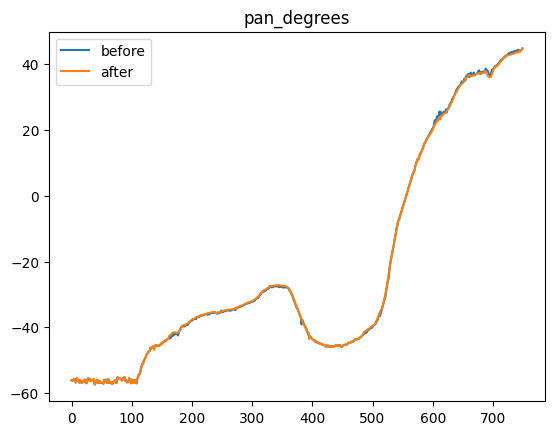

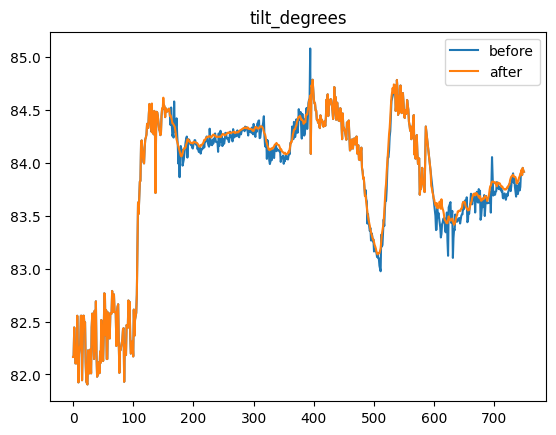

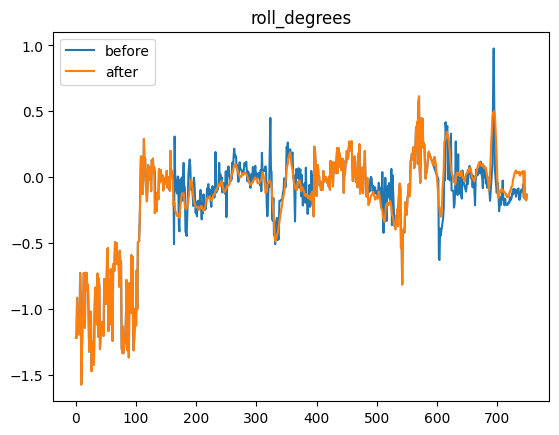

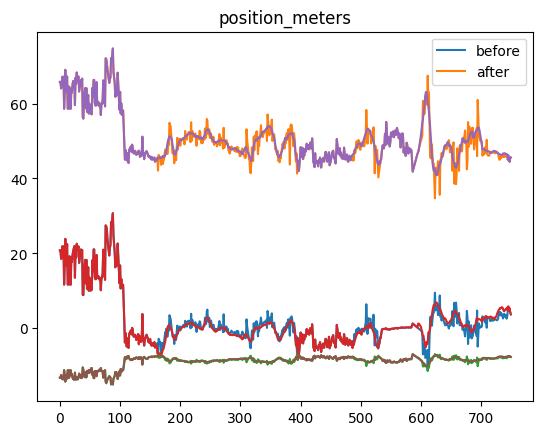

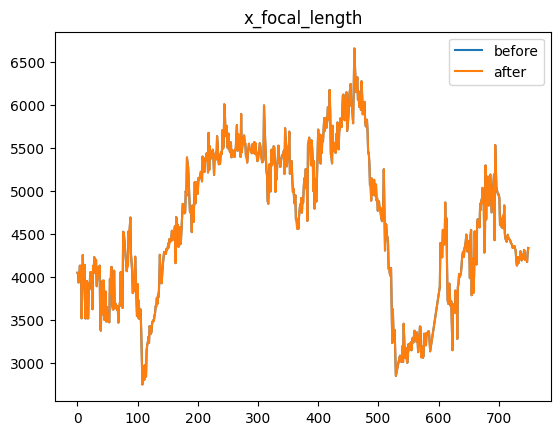

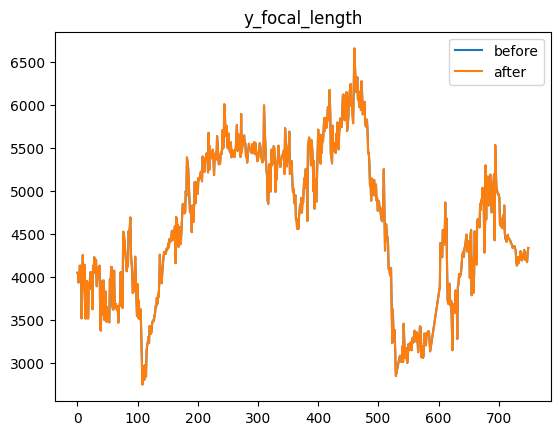

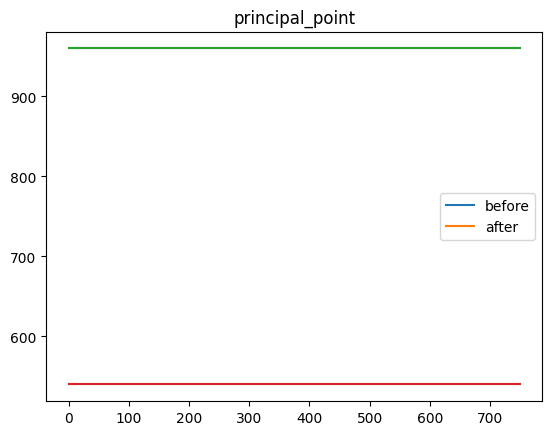

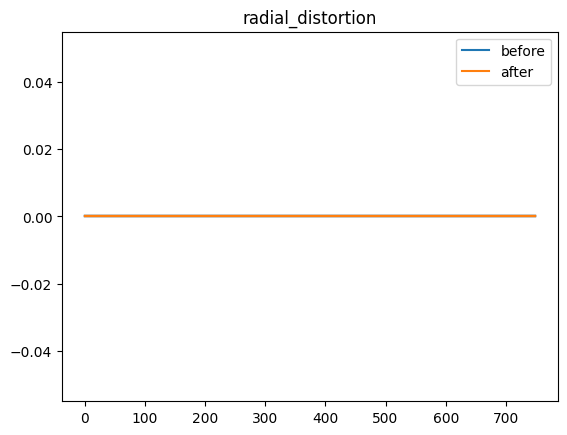

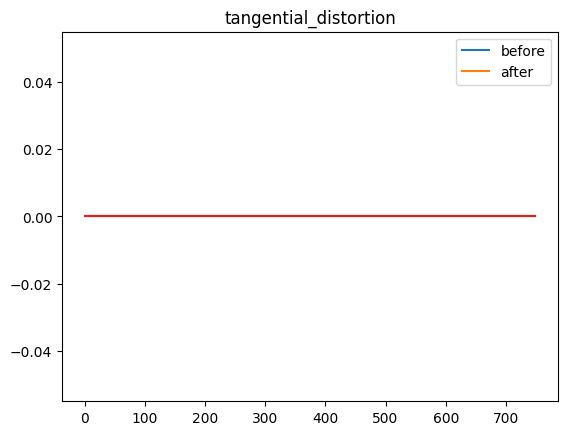

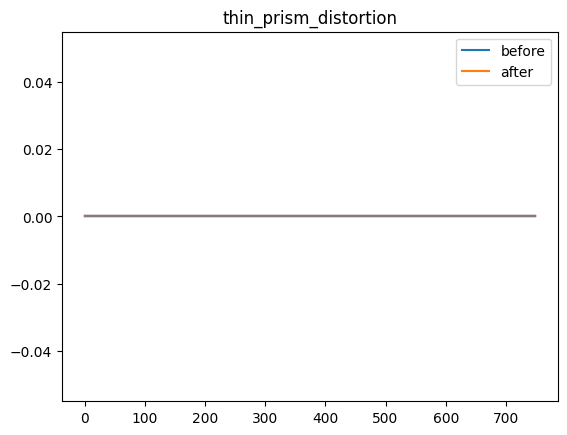

In [61]:
# Compare the original and the modified camera parameters
for key in finalIndCamParams.keys():
    # plt.figure(figsize=(15, 15))
    plt.plot(correctedIndCamParams[key])
    # plt.plot(testIndCamParams[key])
    plt.plot(finalIndCamParams[key])
    plt.title(key)
    plt.legend(["before", "after"])
    plt.show()

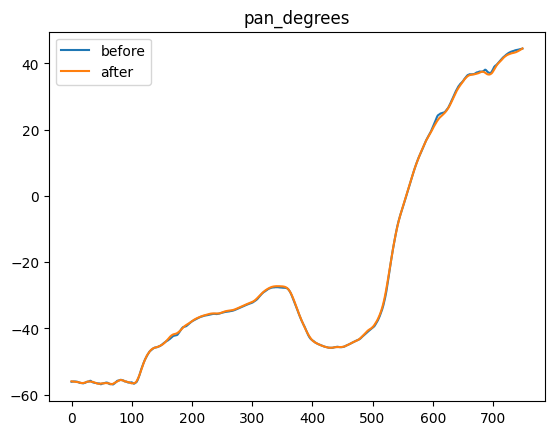

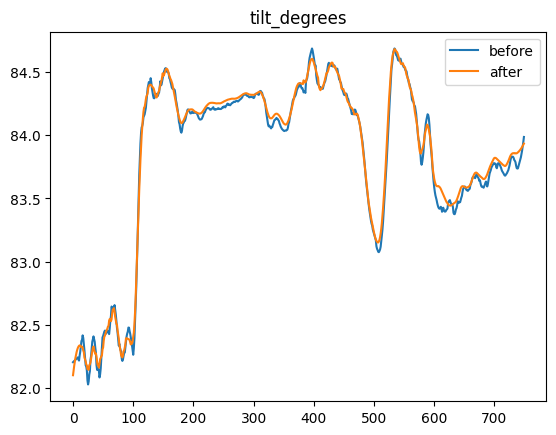

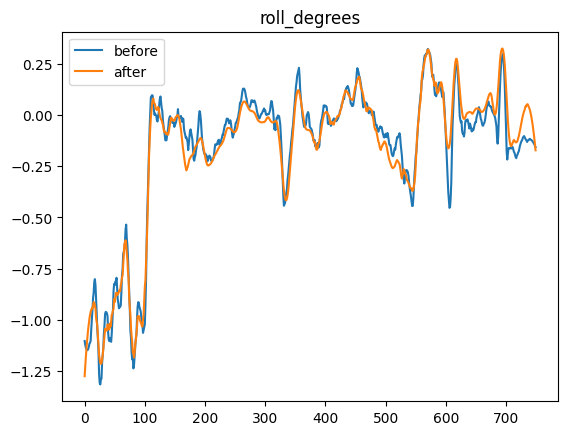

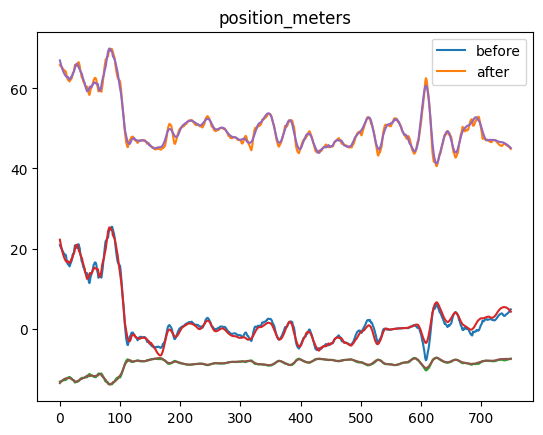

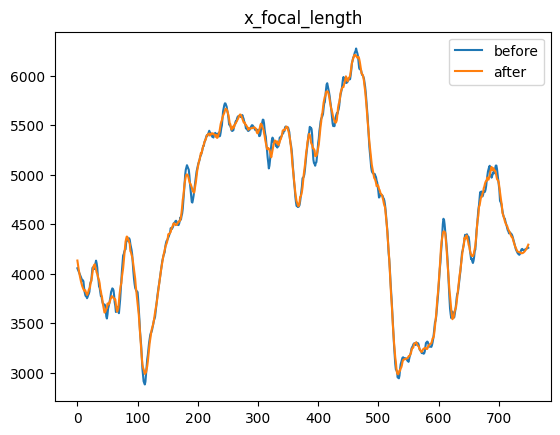

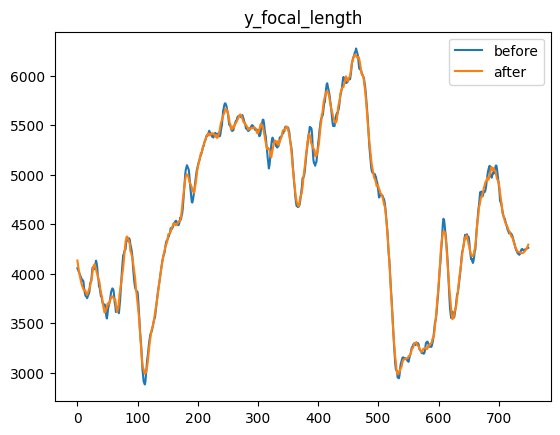

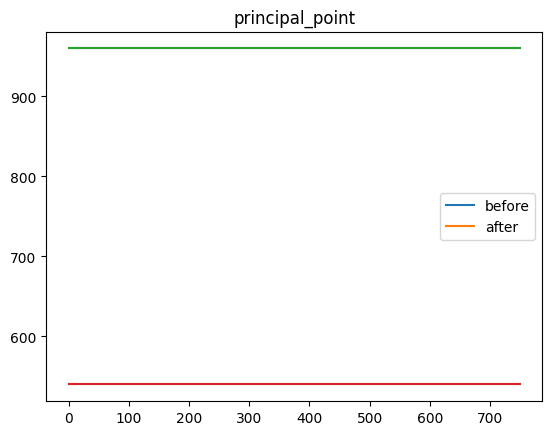

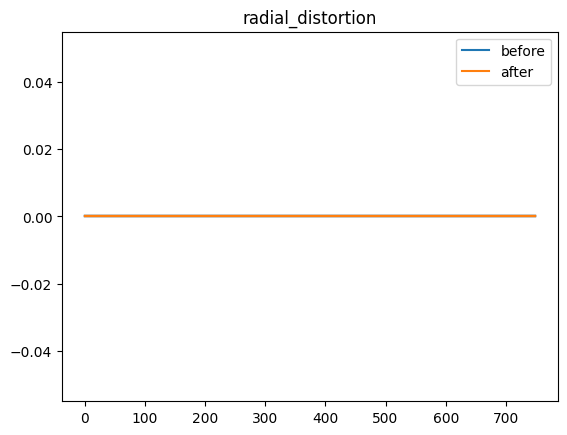

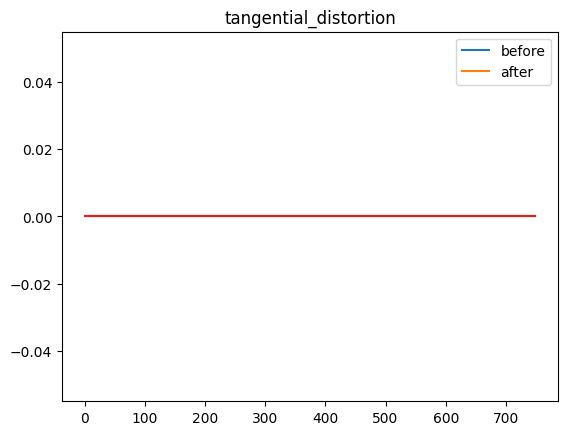

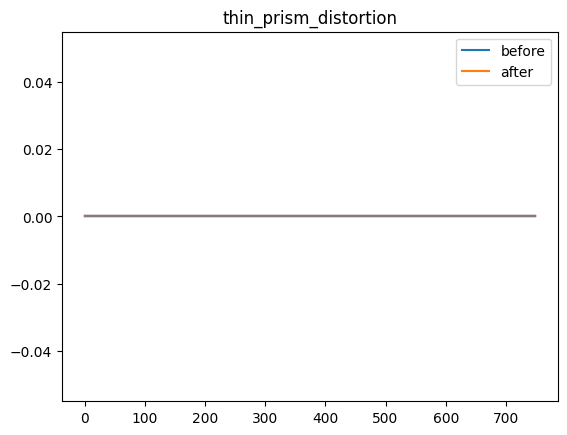

In [62]:
finalSmoothedIndCamParams = deepcopy(finalIndCamParams)
for key in finalIndCamParams.keys():
    finalSmoothedIndCamParams[key] = savgol_filter(finalIndCamParams[key], 25, 2, axis=0)
# clamp values of radial_distortion, tangential_distortion and thin_prism_distortion btw 0 and +inf
for key in ["radial_distortion", "tangential_distortion", "thin_prism_distortion"]:
    finalSmoothedIndCamParams[key] = np.maximum(finalSmoothedIndCamParams[key], 0)
for key in finalSmoothedIndCamParams.keys():
    plt.plot(smoothedIndCamParams[key])
    # plt.plot(testIndCamParams[key])
    plt.plot(finalSmoothedIndCamParams[key])
    plt.legend(["before", "after"])
    plt.title(key)
    plt.show()

In [63]:
finalSmoothedCamParams = [dict(zip(finalSmoothedIndCamParams.keys(), [finalSmoothedIndCamParams[key][i] for key in finalSmoothedIndCamParams.keys()])) for i in range(len(camParams))]

In [ ]:
# cv2.namedWindow('image')
# cv2.moveWindow('image', 30, 40)

# for i in range(750):
# 	imgWithBanners = cv2.imread(imgPath + str(i).zfill(6) + '.png')
# 	cam.from_json_parameters(finalSmoothedCamParams[i])
# 	for side in sides:
# 		pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
# 		pts2D[1][0] = pts2D[0][0]
# 		pts2D[2][0] = pts2D[3][0]
# 		if np.any(pts2D == 0):  # pts are not in the image
# 			continue
# 		cv2.polylines(imgWithBanners, [pts2D.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
# 	cv2.imshow('image', imgWithBanners)
# 	cv2.waitKey(20)

# cv2.destroyAllWindows()

(802, 1525, 3)

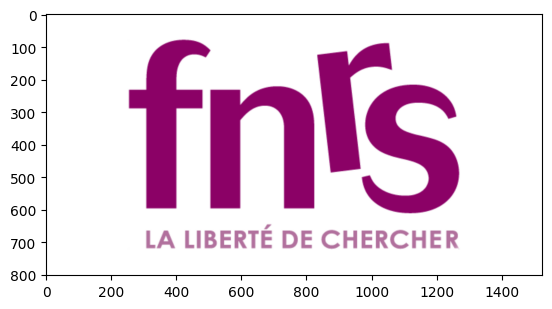

In [4]:
# logo = cv2.imread('University_of_Liège_logo.png')
# logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
# logo = cv2.imread('logo-white.png')
# logo = cv2.copyMakeBorder(logo, 0, 0, 183, 183, cv2.BORDER_CONSTANT, value=(0, 0, 0))
# logo = cv2.imread('EVS_LOGO_RGB.png')
# logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
# logo = cv2.imread('brand-ressources_logos-examples_2_0.png')
# logo = logo[96:-96] # crop pixels from the top and bottom
# # logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(77, 61, 49))
# logo = cv2.imread('pixelcut-export (1).png')

# logo = cv2.imread('FRS_FNRS_BLACK_transp.png')
logo = cv2.imread('FRS-FNRS_rose_transp.png')
logo = cv2.copyMakeBorder(logo, 0, 0, logo.shape[1]//4, logo.shape[1]//4, cv2.BORDER_CONSTANT, value=(255, 255, 255))
logo = cv2.copyMakeBorder(logo, logo.shape[0]//8, logo.shape[0]//8, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
scale = 1525.0 / logo.shape[1]
logo = cv2.resize(logo, (0, 0), fx=scale, fy=scale)

cv2.imwrite('FRS-FNRS_rose_transp_resized.png', logo)

logo[logo == 0] = 1
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
logo.shape

1.8379280949813037
left
bannerBeginning: 5
nLogosInBanner: 41
cut: 315
(408, 32766, 3)
middle
bannerBeginning: 315
nLogosInBanner: 61
cut: 475
(277, 32766, 3)
right
bannerBeginning: 475
nLogosInBanner: 41
cut: 785
(408, 32766, 3)


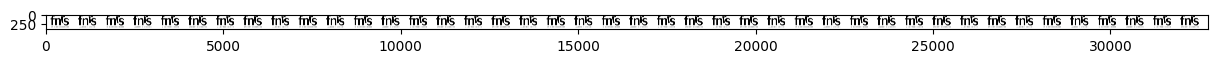

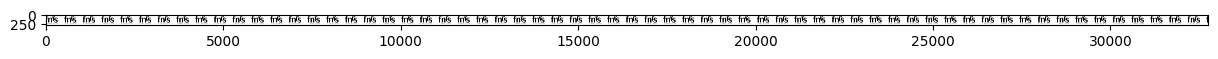

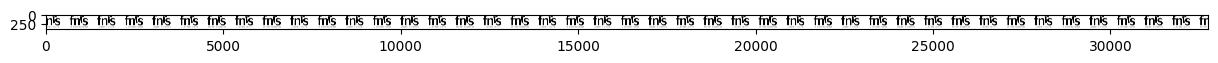

In [65]:
logoBanners = dict()
cut = 5
logoWidthInMeters = height * (logo.shape[1] / logo.shape[0])
print(logoWidthInMeters)
for side in sides:
    print(side)
    if side == 'middle':
        logoBannerLen = bannersDims['right']['dist'] - bannersDims['left']['dist']
    else:
        logoBannerLen = -2 * bannersDims['middle']['dist']
    bannerBeginning = cut
    print('bannerBeginning:', bannerBeginning)
    logoBannerLen -= ((logo.shape[1] - bannerBeginning) / logo.shape[1]) * logoWidthInMeters

    # print(logoBannerLen, logo.shape[1], logoWidthInMeters, logoBannerLen / logoWidthInMeters, np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32), logoBannerLen / logoWidthInMeters * logo.shape[1])
    nLogosInBanner = np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32)
    print('nLogosInBanner:', nLogosInBanner)
    rest = logoBannerLen / logoWidthInMeters - nLogosInBanner
    cut = np.round(rest * logo.shape[1]).astype(np.int32)
    print('cut:', cut)
    # print(np.round(rest * logo.shape[1]).astype(np.int32))
    tmpBanner = np.concatenate([logo[:, bannerBeginning:]] + [logo for _ in range(nLogosInBanner)] + [logo[:, :cut]], axis=1)
    if tmpBanner.shape[1] >= 32766:
        # Resize to a width of 32766 pixels, keep the aspect ratio
        tmpBanner = cv2.resize(tmpBanner, (32766, int(32766 * (tmpBanner.shape[0] / tmpBanner.shape[1]))))
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(tmpBanner, cv2.COLOR_BGR2RGB))
    print(tmpBanner.shape)
    logoBanners[side] = tmpBanner

In [ ]:
# # cv2.namedWindow('image')
# # cv2.moveWindow('image', 30, 40)

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
# out = cv2.VideoWriter('360_video_with_logo_finalsmooth.mp4', fourcc, 25, (1920, 1080))

# for i in tqdm(range(750)):
# 	img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
# 	tmp = np.zeros_like(img)
# 	cam.from_json_parameters(finalSmoothedCamParams[i])
# 	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# 	binMask = np.uint8(mask > 0)
# 	contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 	largest_contour = max(contours, key=cv2.contourArea)
# 	biggestBloBMask = np.zeros(mask.shape, np.uint8)
# 	cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
# 	mask = np.bitwise_and(mask, biggestBloBMask)
# 	for side in sides:
# 		pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
# 		pts2D[1][0] = pts2D[0][0]
# 		pts2D[2][0] = pts2D[3][0]
# 		if np.any(pts2D == 0):  # pts are not in the image
# 			continue
# 		tmpHeight, tmpWidth = logoBanners[side].shape[:2]
# 		srcPts = np.array([[0, tmpHeight], [0, 0], [tmpWidth, 0], [tmpWidth, tmpHeight]], dtype=np.float32)
# 		dstPts = np.array(pts2D, dtype=np.float32)
# 		M = cv2.getPerspectiveTransform(srcPts, dstPts)
# 		tmp = cv2.bitwise_or(tmp, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))

# 	# plt.imshow(cv2.cvtColor(tmp	, cv2.COLOR_BGR2RGB))
# 	binMask = np.bitwise_and(mask > 0, mask < 3)
# 	img[binMask] = tmp[binMask]

# 	out.write(img)

# 	# cv2.imshow('image', img)
# 	# cv2.waitKey(20)

# out.release()
# # cv2.destroyAllWindows()

In [66]:
def line_through_2_points(p1, p2):
    """
    Returns the coefficients of the line passing through the 2 points p1 and p2
    :param p1: point 1
    :param p2: point 2
    :return: m, p where y = m*x + p
    """
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    p = p1[1] - m * p1[0]
    return m, p

In [ ]:
# # Create an image of size 50x50 with only black pixels
# img = np.zeros((50, 50, 3), dtype=np.uint8)
# img[:25, :25] = [255, 255, 255]
# plt.imshow(img)
# blackCond = np.all(img == 0, axis=2)
# print(blackCond)
# plt.figure()
# plt.imshow(blackCond.astype(np.uint8) * 255, cmap='gray')

In [68]:
speed = 1.75  # m/s
fps = 25
# compute speed in pixels per frame
speed = speed * logo.shape[1] / fps / logoWidthInMeters
speed

58.0817064016239

In [71]:
bannersDims['middle']['pts3D']

array([[-57.02315909, -38.78310245,   0.        ],
       [-57.02315909, -38.78310245,  -0.9665694 ],
       [ 57.12137937, -38.78310245,  -0.9665694 ],
       [ 57.12137937, -38.78310245,   0.        ]])

In [73]:
bannersDims['right']['dist'], bannersDims['left']['dist']

(57.121379372977415, -57.023159087413134)

In [88]:
# cv2.namedWindow('image')
# cv2.moveWindow('image', 30, 40)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('360_video_with_logo_blended_moving.mp4', fourcc, 25, (1920, 1080))

speed = 1.75  # m/s
fps = 25
# compute speed in pixels per frame
speed = speed * logo.shape[1] / fps / logoWidthInMeters

for i in tqdm(range(250)):

    logoBanners = dict()
    cut = int(round(i * speed)) % logo.shape[1]
    # cut = 0
    # print('cut:', cut)
    logoWidthInMeters = height * (logo.shape[1] / logo.shape[0])
    # print(logoWidthInMeters)
    for side in sides:
        # print(side)
        if side == 'middle':
            logoBannerLen = bannersDims['right']['dist'] - bannersDims['left']['dist']
        else:
            logoBannerLen = -2 * bannersDims['middle']['dist']
        bannerBeginning = cut
        # print('bannerBeginning:', bannerBeginning)
        logoBannerLen -= ((logo.shape[1] - bannerBeginning) / logo.shape[1]) * logoWidthInMeters

        # print(logoBannerLen, logo.shape[1], logoWidthInMeters, logoBannerLen / logoWidthInMeters, np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32), logoBannerLen / logoWidthInMeters * logo.shape[1])
        nLogosInBanner = np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32)
        # print('nLogosInBanner:', nLogosInBanner)
        rest = logoBannerLen / logoWidthInMeters - nLogosInBanner
        cut = np.round(rest * logo.shape[1]).astype(np.int32)
        # print('cut:', cut)
        # print(np.round(rest * logo.shape[1]).astype(np.int32))
        tmpBanner = np.concatenate([logo[:, bannerBeginning:]] + [logo for _ in range(nLogosInBanner)] + [logo[:, :cut]], axis=1)
        if tmpBanner.shape[1] >= 32766:
            # Resize to a width of 32766 pixels, keep the aspect ratio
            tmpBanner = cv2.resize(tmpBanner, (32766, int(32766 * (tmpBanner.shape[0] / tmpBanner.shape[1]))))
        # plt.figure(figsize=(15, 15))
        # plt.imshow(cv2.cvtColor(tmpBanner, cv2.COLOR_BGR2RGB))
        # print(tmpBanner.shape)
        logoBanners[side] = tmpBanner

    # if i == 0:
    # 	plt.figure()
    # 	plt.imshow(cv2.cvtColor(logoBanners['left'], cv2.COLOR_BGR2RGB))

    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    cam.from_json_parameters(finalSmoothedCamParams[i])
    mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
    binMask = np.uint8(mask > 0)
    contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    biggestBloBMask = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
    mask = np.bitwise_and(mask, biggestBloBMask)
    maskRGB = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # values in maks ranged from 0 to 3, resulting in a maskRGB with values from 0 to 3 and barely visible
    maskRGB = cv2.multiply(maskRGB, 225 / mask.max())
    tmp = np.zeros_like(img)
    tmp2 = np.zeros_like(img)
    for side in sides:
        # if side != 'middle':
        # 	continue
        # print(side)
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        # print(pts2D)
        # print(np.any(np.all(pts2D == 0, axis=1) == True))
        # print(pts2D[0][0] < 0 and pts2D[3][0] < 0)
        # print(pts2D[0][0] >= img.shape[1] and pts2D[3][0] >= img.shape[1])
        if np.any(np.all(pts2D == 0, axis=1) == True) or (pts2D[0][0] < 0 and pts2D[3][0] < 0) or (pts2D[0][0] >= img.shape[1] and pts2D[3][0] >= img.shape[1]):   # pts are not in the image
            continue

        tmpHeight, tmpWidth = logoBanners[side].shape[:2]
        # srcPtsTmp = np.array([[0, tmpHeight-1], [0, 0], [tmpWidth-1, 0], [tmpWidth-1, tmpHeight-1]], dtype=np.float32)
        # print(srcPts)
        dstPts = np.array(pts2D, dtype=np.float32)
        # Mtemp = cv2.getPerspectiveTransform(srcPtsTmp, dstPts)
        # tmp2 = cv2.bitwise_or(tmp2, cv2.warpPerspective(logoBanners[side], Mtemp, (img.shape[1], img.shape[0])))
        # print(dstPts)
        # M = cv2.getPerspectiveTransform(srcPts, dstPts)
        # tmp2 = cv2.bitwise_or(tmp2, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))
        # Minverse = cv2.getPerspectiveTransform(dstPts, srcPts)
        # unWarpedBanner = cv2.warpPerspective(img, Minverse, (tmpWidth, tmpHeight))
        # cv2.imshow('image', unWarpedBanner)
        # cv2.waitKey(0)

        increase = 50  # ! Maybe try with smg like int(tmpHeight * 0.12)
        srcPts = np.array([[0, tmpHeight-1+increase], [0, increase], [tmpWidth-1, increase], [tmpWidth-1, tmpHeight-1+increase]], dtype=np.float32)
        Minverse = cv2.getPerspectiveTransform(dstPts, srcPts)
        M = cv2.getPerspectiveTransform(srcPts, dstPts)
        # unWarpedBanner = cv2.warpPerspective(img, Minverse2, (tmpWidth, tmpHeight + 2*increase))
        # cv2.imshow('image', unWarpedBanner)
        # cv2.waitKey(0)

        # unWarpedMask = cv2.warpPerspective(maskRGB, Minverse2, (tmpWidth, tmpHeight + 2*increase))
        # cv2.imshow('image', unWarpedMask)
        # cv2.waitKey(0)


        warpedMask = cv2.warpPerspective(mask, Minverse, (tmpWidth, tmpHeight + 2*increase))
        binWarpedMask = warpedMask > 0
        y, x = np.where(binWarpedMask)
        if len(y) == 0 or len(x) == 0:
            continue
        poly = PolynomialFeatures(degree=2, include_bias=True)
        X = poly.fit_transform(x.reshape(-1, 1))
        reg = LinearRegression().fit(X, y)
        Y = reg.predict(X)
        width = np.mean(abs(y - Y)) * 4
        # MInverse = cv2.getPerspectiveTransform(dstPts, srcPts)  # could also use np.linalg.inv(M) but cv2.getPerspectiveTransform is 3 times faster
        
        x = np.arange(32766, step=762)
        xRegression = np.arange(32766)
        xPoly = poly.fit_transform(xRegression.reshape(-1, 1))
        yc = reg.predict(xPoly)
        yt = yc - width/2
        yb = yc + width/2
        topLinePts = np.float32([[x_, y_] for x_, y_ in zip(xRegression, yt)]).reshape(-1, 1, 2)
        bottomLinePts = np.float32([[x_, y_] for x_, y_ in zip(xRegression, yb)]).reshape(-1, 1, 2)
        topLinePts = cv2.perspectiveTransform(topLinePts, M).reshape(-1, 2)
        bottomLinePts = cv2.perspectiveTransform(bottomLinePts, M).reshape(-1, 2)
        srcPts2 = np.float32([[0, 0], [761, 0], [761, logoBanners[side].shape[0]-1], [0, logoBanners[side].shape[0]-1]])

        for x_ in x:
            billPts = np.float32([topLinePts[x_], topLinePts[x_+761], bottomLinePts[x_+761], bottomLinePts[x_]])
            M2 = cv2.getPerspectiveTransform(srcPts2, billPts)
            warpedLogo = cv2.warpPerspective(logoBanners[side][:, x_:x_+762], M2, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)  # flags=cv2.INTER_LINEAR might be better ?
            tmp = cv2.bitwise_or(tmp, warpedLogo)
            # warpedLogo = cv2.warpPerspective(logoBanners[side][:, x_:x_+762], M2, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
            # tmp2 = cv2.bitwise_or(tmp2, warpedLogo)


    binMask = np.bitwise_and(mask > 0, mask < 3)
    # img[binMask] = tmp2[binMask]
    # cv2.imshow('image', img)
    # cv2.waitKey(0)


    # img = cv2.imread(imgPath + str(i).zfill(6) + '.png')

    #! Set background of tmp to white
    # ? but here it is black, might set it to main colour of image
    tmp[np.where((tmp == [0, 0, 0]).all(axis=2))] = [0, 0, 0]
    # if i == 0:
    # 	plt.imshow(tmp)
    img[binMask] = tmp[binMask]
    # cv2.imshow('image', img)
    # cv2.waitKey(1)
    # cv2.imshow('image', tmp2)
    # cv2.waitKey(0)
    # cv2.imshow('image', img)
    # cv2.waitKey(1)


    # hsv_img = cv2.cvtColor(cv2.imread(imgPath + str(i).zfill(6) + '.png'), cv2.COLOR_BGR2HSV)
    # h, s, v = cv2.split(hsv_img)
    # meanAdVal = np.mean(v[binMask])
    # meanAdSat = np.mean(s[binMask])
    # print(np.mean(v), np.mean(s))
    # print(meanAdVal, meanAdSat)

    meanAdVal = 175.0
    meanAdSat = 0.5

    # apply a dilation with a cross kernel to the mask to make the mask bigger
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    dilatedBinMask = cv2.dilate(np.uint8(binMask), kernel, iterations=1) > 0

    img2 = deepcopy(img)
    img2[dilatedBinMask] = cv2.GaussianBlur(img, (3, 3), 0)[dilatedBinMask]

    # hsv_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    # saturation_factor = 0.5
    # h, s, v = cv2.split(hsv_img2)
    # s = np.clip(s * saturation_factor, 0, 255).astype(np.uint8)
    # hsv_img2 = cv2.merge([h, s, v])
    # img2[dilatedBinMask] = cv2.cvtColor(hsv_img2, cv2.COLOR_HSV2BGR)[dilatedBinMask]

    alpha = 0.3
    img3 = cv2.addWeighted(img, alpha, img2, 1.0 - alpha, 0)
    # cv2.imshow('image', img3)
    # cv2.waitKey(0)

    hsv_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img3)
    # print(meanAdVal, np.mean(v[binMask]))
    # print(meanAdSat, np.mean(s[binMask]))
    s = meanAdSat * s / np.mean(s[binMask])
    v = meanAdVal * v / np.mean(v[binMask])
    s = np.clip(s, 0, 255).astype(np.uint8)
    v = np.clip(v, 0, 255).astype(np.uint8)
    # print(meanAdSat, np.mean(s[binMask]))
    # print(meanAdVal, np.mean(v[binMask]))
    hsv_img3 = cv2.merge([h, s, v])
    # cv2.imshow('image', cv2.cvtColor(hsv_img3, cv2.COLOR_HSV2BGR))
    # cv2.waitKey(0)
    img4 = deepcopy(img3)
    img4[binMask] = cv2.cvtColor(hsv_img3, cv2.COLOR_HSV2BGR)[binMask]


    # cv2.imshow('image', img4)
    # cv2.waitKey(1)

    # plt.figure(figsize=(15, 15))
    # plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

    # cv2.imshow('image', maskRGB)
    # cv2.waitKey(0)

    # cv2.imshow('image', img)
    # cv2.waitKey(0)

    # cv2.imshow('image', img2)
    # cv2.waitKey(0)

    # cv2.imshow('image', cv2.imread(imgPath + str(i).zfill(6) + '.png'))
    # cv2.waitKey(0)

    out.write(img4)

cv2.destroyAllWindows()
out.release()

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [05:52<00:00,  1.41s/it]


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('360_video_black_banners.mp4', fourcc, 25, (1920, 1080))

for i in tqdm(range(750)):
    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
    binMask = np.bitwise_and(mask > 0, mask < 3)
    img[binMask] = [0,0,0]
    out.write(img)
    
out.release()

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('360_RGB_masks_blended.mp4', fourcc, 25, (1920, 1080))

for i in tqdm(range(750)):
    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
    maskRGB = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    maskRGB[np.all(maskRGB == [0,0,0], axis=2)] = [0,0,0]
    maskRGB[np.all(maskRGB == [1,1,1], axis=2)] = [255,0,0]
    maskRGB[np.all(maskRGB == [2,2,2], axis=2)] = [0,255,0]
    maskRGB[np.all(maskRGB == [3,3,3], axis=2)] = [0,0,255]
    alpha = 0.60
    img = cv2.addWeighted(img, alpha, maskRGB, 1.0 - alpha, 0)
    out.write(img)
    
out.release()

In [ ]:
i = 0
mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
maskRGB = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
maskRGB[np.all(maskRGB == [0,0,0], axis=2)] = [0,0,0]
maskRGB[np.all(maskRGB == [1,1,1], axis=2)] = [255,255,255]
maskRGB[np.all(maskRGB == [2,2,2], axis=2)] = [0,255,0]
maskRGB[np.all(maskRGB == [3,3,3], axis=2)] = [0,0,255]
plt.imshow(cv2.cvtColor(maskRGB, cv2.COLOR_BGR2RGB))

In [ ]:
# Create a 1080x1920 grid image with white background, black lines and squares of 5x5 pixels
squareSize = 446//3
gridWidth = 1482
gridHeight = 446
lineThickness = 20
lineColor = (242, 242, 242)
grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
grid.fill(0)
for i in range(0, gridWidth, squareSize):
    cv2.line(grid, (i, 0), (i, gridHeight), lineColor, lineThickness)
for i in range(0, gridHeight, squareSize):
    cv2.line(grid, (0, i), (gridWidth, i), lineColor, lineThickness)
# plot grid
plt.figure(figsize=(15,15))
plt.imshow(grid)
# save image with a dpi of 300
# plt.imsave('grid.png', grid, dpi=300)
logo = grid

logoBanners = dict()
cut = 0
logoWidthInMeters = height * (logo.shape[1] / logo.shape[0])
print(logoWidthInMeters)
for side in sides:
    print(side)
    if side == 'middle':
        logoBannerLen = bannersDims['right']['dist'] - bannersDims['left']['dist']
    else:
        logoBannerLen = -2 * bannersDims['middle']['dist']
    bannerBeginning = cut
    print('bannerBeginning:', bannerBeginning)
    logoBannerLen -= ((logo.shape[1] - bannerBeginning) / logo.shape[1]) * logoWidthInMeters

    # print(logoBannerLen, logo.shape[1], logoWidthInMeters, logoBannerLen / logoWidthInMeters, np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32), logoBannerLen / logoWidthInMeters * logo.shape[1])
    nLogosInBanner = np.floor(logoBannerLen / logoWidthInMeters).astype(np.int32)
    print('nLogosInBanner:', nLogosInBanner)
    rest = logoBannerLen / logoWidthInMeters - nLogosInBanner
    cut = np.round(rest * logo.shape[1]).astype(np.int32)
    print('cut:', cut)
    # print(np.round(rest * logo.shape[1]).astype(np.int32))
    tmpBanner = np.concatenate([logo[:, bannerBeginning:]] + [logo for _ in range(nLogosInBanner)] + [logo[:, :cut]], axis=1)
    if tmpBanner.shape[1] >= 32766:
        # Resize to a width of 32766 pixels, keep the aspect ratio
        tmpBanner = cv2.resize(tmpBanner, (32766, int(32766 * (tmpBanner.shape[0] / tmpBanner.shape[1]))))
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(tmpBanner, cv2.COLOR_BGR2RGB))
    print(tmpBanner.shape)
    logoBanners[side] = tmpBanner

In [ ]:
cv2.namedWindow('image')
cv2.moveWindow('image', 30, 40)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
out = cv2.VideoWriter('360_video_with_grid_and_pitch_lines.mp4', fourcc, 25, (1920, 1080))

for i in tqdm(range(750)):

    img = cv2.imread(imgPath + str(i).zfill(6) + '.png')
    cam.from_json_parameters(camParams[i])
    mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
    binMask = np.uint8(mask > 0)
    contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    biggestBloBMask = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
    mask = np.bitwise_and(mask, biggestBloBMask)
    tmp = np.zeros_like(img)
    tmp2 = np.zeros_like(img)

    for side in sides:
        # if side != 'left':
        # 	continue
        # print(side)
        pts2D = np.array([cam.project_point(p, distort=False)[:2] for p in bannersDims[side]['pts3D']])
        pts2D[1][0] = pts2D[0][0]
        pts2D[2][0] = pts2D[3][0]
        # print(pts2D)
        # print(np.any(np.all(pts2D == 0, axis=1) == True))
        # print(pts2D[0][0] < 0 and pts2D[3][0] < 0)
        # print(pts2D[0][0] >= img.shape[1] and pts2D[3][0] >= img.shape[1])
        if np.any(np.all(pts2D == 0, axis=1) == True) or (pts2D[0][0] < 0 and pts2D[3][0] < 0) or (pts2D[0][0] >= img.shape[1] and pts2D[3][0] >= img.shape[1]):   # pts are not in the image
            continue

        tmpHeight, tmpWidth = logoBanners[side].shape[:2]
        # srcPtsTmp = np.array([[0, tmpHeight-1], [0, 0], [tmpWidth-1, 0], [tmpWidth-1, tmpHeight-1]], dtype=np.float32)
        # print(srcPts)
        dstPts = np.array(pts2D, dtype=np.float32)
        # Mtemp = cv2.getPerspectiveTransform(srcPtsTmp, dstPts)
        # tmp2 = cv2.bitwise_or(tmp2, cv2.warpPerspective(logoBanners[side], Mtemp, (img.shape[1], img.shape[0])))
        # print(dstPts)
        # M = cv2.getPerspectiveTransform(srcPts, dstPts)
        # tmp2 = cv2.bitwise_or(tmp2, cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0])))
        # Minverse = cv2.getPerspectiveTransform(dstPts, srcPts)
        # unWarpedBanner = cv2.warpPerspective(img, Minverse, (tmpWidth, tmpHeight))
        # cv2.imshow('image', unWarpedBanner)
        # cv2.waitKey(0)

        increase = int(tmpHeight * 0.12)
        srcPts = np.array([[0, tmpHeight-1-increase], [0, increase], [tmpWidth-1, increase], [tmpWidth-1, tmpHeight-1-increase]], dtype=np.float32)
        Minverse = cv2.getPerspectiveTransform(dstPts, srcPts)
        M = cv2.getPerspectiveTransform(srcPts, dstPts)
        warpedLogo = cv2.warpPerspective(logoBanners[side], M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
        tmp = cv2.bitwise_or(tmp, warpedLogo)
        # cv2.imshow('image', warpedLogo)
        # cv2.waitKey(0)

    cam.draw_corners(img)
    cam.draw_pitch(img)
    binMask = np.bitwise_and(mask > 0, mask < 3)
    img[binMask] = tmp[binMask]
    out.write(img)
    cv2.imshow('image', img)
    cv2.waitKey(1)

cv2.destroyAllWindows()
out.release()